<a href="https://colab.research.google.com/github/Maziger/master-reinforcement-learning/blob/main/Notebooks/13_approx_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook pre steps

In [1]:
#@title Installations

# ALWAYS SAVE YOUR OWN COPY OF THIS NOTEBOOK: File > Save a copy in Drive
# IF DANISH MENU DO: Hjælp > Engelsk version
# To clear output do: Edit > Clear all outputs

## Useful shortscuts
# Run current cell: Cmd+Enter
# Run current cell and goto next: Shift+Enter
# Run selection (or line if no selection): Cmd+Shift+Enter

# install missing packages
!pip install dfply
!python --version
# !pip install plotly --quiet
import plotly.io as pio
pio.renderers.default = "colab"
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from dfply import *
from plotnine import *
import matplotlib.pyplot as plt
import numpy as np  # RNG and vector ops
import pandas as pd  # tabular outputs
import math
import random
from IPython.display import display, Markdown
from tqdm import tqdm
# import json
# from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 12.2 MB/s eta 0:00:00
Python 3.12.12


# On-policy Control with approximation

In the previous module, the focus was on predicting the state values of a policy using function approximation. Here, the emphasis is on control, specifically finding an optimal policy through function approximation of *action values* $	\hat q(s, a, \textbf{w})$. Once again, the focus remains on **on-policy** methods.

In the episodic case, the extension from prediction to control is straightforward, but in the continuing case, discounting is not suitable to find an optimal policy. Surprisingly, once we have a genuine function approximation, we have to give up discounting and switch to an “average-reward” formulation.


## Episodic Semi-gradient Control

Consider episodic tasks. To find a good policy, the action-value function is approximated by a differentiable function $\hat q(s,a,\mathbf{w}) \approx q^\pi(s,a)$ with weight vector $\mathbf{w}$.

Training examples now take the form $(S_t, A_t) \mapsto U_t$, where $U_t$ is any target approximating $q^\pi(S_t,A_t)$. For instance, for a one-step semi-gradient, we have   
$$
U_t = R_{t+1} + \gamma\, \hat q(S_{t+1}, A_{t+1}, \mathbf{w}_t),
$$
which bootstraps from the next state–action estimate produced by the same $\varepsilon$-greedy policy.

Learning is done using semi-gradient stochastic gradient descent on the squared error, yielding the generic update
$$
\mathbf{w}_{t+1} = \mathbf{w}_t + \alpha\big[U_t - \hat q(S_t,A_t,\mathbf{w}_t)\big]\nabla_{\mathbf{w}} \hat q(S_t,A_t,\mathbf{w}_t).
$$
This is the direct action-value analogue of semi-gradient TD for state values.

If the action set is discrete and not too
large, then we can use the techniques already developed in previous chapters.


Let us implement the episodic Semi-Gradient Sarsa algorithm (Sutton et al. p244):

![alg fig](https://raw.githubusercontent.com/bss-osca/rl/refs/heads/master/book/img/1001_Ep_Semi_Grad_Sarsa.png)

In [2]:
#@title Episodic semi-gradient SARSA

def ep_semi_grad_sarsa(
    env,
    episodes,
    gamma,
    eps,
    q_hat,
    s_start=None,
    callback=None,
    trace=None,
    max_steps=None,
    eps_decay=None  # e.g., 0.995 or a callable: lambda ep, eps: ...
):
    """
    Episodic Semi-Gradient SARSA.

    Params:
        env: has get_actions(s), get_step(s, a), reset()
        episodes: number of episodes
        gamma: discount factor in [0, 1]
        eps: initial epsilon for epsilon-greedy
        q_hat: approximator with:
              eval(s, a) -> float
              train(s, a, target) -> None  (performs semi-gradient update internally)
        s_start: None -> use env.reset(); else either a single start state or
                 a sequence to sample from.
        callback(ep, q_hat, trace, info): called at end of each episode (1-based ep)
        trace: passed through to callback
        max_steps: optional cap on steps per episode
        eps_decay: optional epsilon schedule. If float in (0,1), eps *= eps_decay each ep.
                   If callable, eps = eps_decay(ep, eps).
    """

    def argmax_rand(values):
        """Index of a max value, breaking ties uniformly at random."""
        vmax = np.max(values)
        idxs = np.flatnonzero(values == vmax)
        return np.random.choice(idxs)

    def policy(s, eps_curr):
        """Epsilon-greedy over env.get_actions(s) using q_hat."""
        actions = env.get_actions(s)
        if len(actions) == 0:
            raise ValueError("env.get_actions(s) returned no actions.")
        if np.random.rand() < eps_curr:
            return np.random.choice(actions)
        q_values = np.array([q_hat.eval(s, a) for a in actions], dtype=float)
        return actions[argmax_rand(q_values)]

    def pick_start(s_start):
        if s_start is None:
            return env.reset()
        if len(s_start) == 1:
            return s_start[0]
        idx = np.random.choice(range(len(s_start)))
        s = s_start[idx]
        return s

    eps_curr = float(eps)


    for ep in tqdm(range(1, episodes + 1), desc="Episode", unit="episode",
                   bar_format='{l_bar}{bar}| {n}/{total} [{elapsed}<{remaining}, {rate_fmt}{postfix}]'):
        s = pick_start(s_start)
        a = policy(s, eps_curr)

        steps = 0
        while True:
            s_n, r, done = env.get_step(s, a)
            # print("s,a,s_n,r,done:",s,a,s_n,r,done)
            if done:
                td_target = r  # Q(s', a') = 0 for terminal
                q_hat.train(s, a, td_target)
                break
            else:
                a_n = policy(s_n, eps_curr)
                td_target = r + gamma * q_hat.eval(s_n, a_n)
                q_hat.train(s, a, td_target)
                s, a = s_n, a_n

            steps += 1
            if max_steps is not None and steps >= max_steps:
                # Force end of episode if a cap is set
                break

        if callback is not None:
            info = {"epsilon": eps_curr, "steps": steps}
            callback(ep, q_hat, trace, info)

        # Update epsilon if requested
        if eps_decay is not None:
            if callable(eps_decay):
                eps_curr = float(eps_decay(ep, eps_curr))
            else:
                eps_curr *= float(eps_decay)
            eps_curr = max(0.0, min(1.0, eps_curr))

Note the following differences in the implementation:

* $\hat{q}$ is a black box trainable function approximator class so  avoid passing around $\mathbf{w}$, computing and storing $\nabla\hat{q}(S,A,\mathbf{w})$ explicitly.
* Don't initialize $\mathbf{w}$ since we may want to continue training.
* Possible to choose start states.
* May use a decay for the epsilon policy.
* Add callback and trace params, so we can track what is going on.

## Seasonal inventory and sales planning

Let us solve the seasonal inventory and sales planning problem in [Example 9.4.4](https://bss-osca.github.io/rl/09_mc.html#sec-mc-seasonal)  

We consider seasonal product such as garden furnitures. Assume that the maximum inventory level is $Q$ items, i.e. we can buy at most $Q$ items at the start of the season for a fixed price. The product can be sold for at most $T$ weeks and at the end of the period (week $T$), the remaining inventory is sold to an outlet store for as scrap price.

Let $s = (q,t)$ denote the state of the system at the start of a week. We have a terminal state (inventory empty). Actions are which price to choose. Let us limit to actions $\{10, 15, 20, 25\}$,

The inventory dynamics and rewards are coded in the environment below:

In [3]:
#@title RL environment - Seasonal

from __future__ import annotations  # forward refs

import numpy as np
import pandas as pd


class RLEnvSeasonal:
    """
    Seasonal single-item pricing/sales environment.

    State space:
      - non-terminal states are strings "q,t" where q∈{1..max_inv}, t∈{1..max_t}
      - terminal state is "0"

    Action space:
      - at t < max_t: choose a price from self.prices (as string)
      - at t == max_t: action is effectively a dummy (we scrap remaining inventory)

    Stochastic demand depends on price via a piecewise curve and has early-season uplift.
    """

    def __init__(self,
                 max_inv: int,
                 max_t: int,
                 scrap_price: float,
                 purchase_price: float,
                 prices: list[float],
                 seed = None) -> None:

        """
        Initializes the seasonal RL environment.

        Args:
            max_inv: Maximum inventory units.
            max_t: Number of selling weeks.
            scrap_price: Value per leftover at final week.
            purchase_price: Unit purchase cost at t=1.
            prices: Allowable sale prices.
        """
        self.max_inv = int(max_inv)
        self.max_t = int(max_t)
        self.scrap_price = float(scrap_price)
        self.purchase_price = float(purchase_price)
        self.prices = list(map(float, prices))
        self.rng = np.random.default_rng(seed)
        self.rng_seed = seed

    def reset(self):
        """
        Reset the environment to the initial state.

        Returns:
            The initial state.
        """
        t = 1  # start at time 1
        q = self.rng.integers(1, self.max_inv + 1)
        return [int(q), t]

    def reset_rng(self):
        """
        Reset the random number generator.

        Returns:
            The initial state.
        """
        self.rng = np.random.default_rng(self.rng_seed)
        return self.reset()

    # ----------------------------- state & action spaces ----------------------

    # def get_states(self) -> list[str]:
    #     """
    #     Return all state keys as strings plus terminal '0'.

    #     Returns:
    #         A list of state identifiers.
    #     """
    #     # Cartesian product of q=1..max_inv and t=1..max_t
    #     grid = pd.MultiIndex.from_product(
    #         [range(1, self.max_inv + 1), range(1, self.max_t + 1)],
    #         names=["q", "t"],
    #     ).to_frame(index=False)
    #     states = [f"{int(row.q)},{int(row.t)}" for row in grid.itertuples(index=False)]
    #     return states + ["0"]

    def get_actions(self, s) -> list:
        """
        Return available actions for state s.

        Args:
            s: The state.

        Returns:
            A list of actions for the given state.
        """
        assert len(s) == 2
        q, t = s[0], s[1]
        assert np.isscalar(t)
        assert 1 <= t <= self.max_t
        if t == self.max_t:
            return [self.scrap_price]
        assert np.isscalar(q)
        assert 1 <= q <= self.max_inv
        return self.prices

    # ----------------------------- demand model --------------------------------

    def get_demand(self, price: float, t: int) -> int:
        """
        Sample a stochastic demand for a given price and week.

        Piecewise base demand:
          - linear between (10,20) and (12,12)
          - linear between (12,12) and (15,10)
          - log tail beyond 15
        Early-season uplift for t <= max_t/2.

        Args:
            price: The price.
            t: The week.

        Returns:
            The sampled demand as an integer.
        """
        # l1: between price 10..12
        # l2: between price 12..15
        # l3: beyond 15, log decay anchored at (15,10)
        if price <= 12.0:
            a = (20.0 - 12.0) / (10.0 - 12.0)
            b = 20.0 - a * 10.0
            d = a * price + b
            d_s = d * self.rng.uniform(0.75, 1.25)
        elif 12.0 <= price <= 15.0:
            a = (12.0 - 10.0) / (12.0 - 15.0)
            b = 12.0 - a * 12.0
            d = a * price + b
            d_s = d * self.rng.uniform(0.75, 1.25)
        else:
            d = -4.0 * np.log(price - 15.0 + 1.0) + 10.0
            d_s = d * self.rng.uniform(1.0, 2.0)
        if t <= self.max_t / 2.0:
            d_s *= self.rng.uniform(1.0, 1.2)
        return int(round(max(0.0, d_s)))

    # ----------------------------- single-step API for RLAgent -----------------

    def get_step(self, s, a: float) -> list:
        """
        One simulated step: given (s,a) -> (s_n, a_n, terminal)

        Args:
            s: The current state (list).
            a: The action taken (scalar).

        Returns:
            The next state, reward, and terminal flag.
        """
        assert np.isscalar(a)
        assert len(s) == 2
        q, t = s[0], s[1]
        assert np.isscalar(q)
        assert np.isscalar(t)
        if q == 0:
            return (None, 0.0, True)
        if t == self.max_t:
            r = self.scrap_price * q
            return (None, r, True)
        price = float(a)
        d = self.get_demand(price, t)
        sold = min(q, d)
        r = price * sold
        if t == 1:
            r -= q * self.purchase_price
        q_n = q - sold
        if q_n == 0:
            return (None, r, True)
        return ([q_n, t+1], r, False)



We define a method `get_step` for getting the next reward and state in an episode. Moreover, a boolean is returned, which is true if we reach the terminal state. Note, here we have no information about transistion probabilities, possible states etc.

Let us have a deeper view of the environment:

In [6]:
# define candidate sale prices
prices = [10, 15, 20, 25]


## Test 1
# instantiate environment
env = RLEnvSeasonal(
    max_inv=100,       # maximum inventory
    max_t=4,          # selling horizon (weeks)
    scrap_price=5.0,   # scrap value at final week
    purchase_price=14.0,  # cost of each unit purchased at t=1
    prices=prices,      # allowable selling prices
    seed=876
)

# Try to pick some state and actions
print("Start episode:")
s = [100,1]
print("Start state:", s)
for _ in range(100):
    actions = env.get_actions(s)
    print("Possible actions", actions)
    a = env.rng.choice(actions)
    print("Pick price:", a)
    s_n, r, done = env.get_step(s, a)
    print("Next state, reward, done:", s_n, r, done)
    s = s_n
    if done:
        break

## Test 2
# instantiate environment
env = RLEnvSeasonal(
    max_inv=100,       # maximum inventory
    max_t=15,          # selling horizon (weeks)
    scrap_price=5.0,   # scrap value at final week
    purchase_price=14.0,  # cost of each unit purchased at t=1
    prices=prices,      # allowable selling prices
    seed=876
)

# Try to pick some state and actions
print("\nStart episode:")
s = env.reset()
print("Start state:", s)
for _ in range(100):
    actions = env.get_actions(s)
    print("Possible actions", actions)
    if 25 in actions:
        a = 25
    else:
        a = env.rng.choice(actions)
    print("Pick price:", a)
    s_n, r, done = env.get_step(s, a)
    print("Next state, reward, done:", s_n, r, done)
    s = s_n
    if done:
        break


Start episode:
Start state: [100, 1]
Possible actions [10.0, 15.0, 20.0, 25.0]
Pick price: 15.0
Next state, reward, done: [91, 2] -1265.0 False
Possible actions [10.0, 15.0, 20.0, 25.0]
Pick price: 15.0
Next state, reward, done: [80, 3] 165.0 False
Possible actions [10.0, 15.0, 20.0, 25.0]
Pick price: 25.0
Next state, reward, done: [79, 4] 25.0 False
Possible actions [5.0]
Pick price: 5.0
Next state, reward, done: None 395.0 True

Start episode:
Start state: [48, 1]
Possible actions [10.0, 15.0, 20.0, 25.0]
Pick price: 25
Next state, reward, done: [47, 2] -647.0 False
Possible actions [10.0, 15.0, 20.0, 25.0]
Pick price: 25
Next state, reward, done: [46, 3] 25.0 False
Possible actions [10.0, 15.0, 20.0, 25.0]
Pick price: 25
Next state, reward, done: [45, 4] 25.0 False
Possible actions [10.0, 15.0, 20.0, 25.0]
Pick price: 25
Next state, reward, done: [44, 5] 25.0 False
Possible actions [10.0, 15.0, 20.0, 25.0]
Pick price: 25
Next state, reward, done: [43, 6] 25.0 False
Possible actions 

### Your turn

Explain the output.

* Short selling season (max_t = 4 weeks)
  * Week 1: Buy 100 items in the beginning at purchase price 14 = 1400
    * Pick randomly (set price at 15)
    * Reward = (15*9=135)-1400 = 1265
    * Inventory drops to 91
    * done = False (so we continue)

* Long selling season (max_t = 15 weeks)

### Control using function approximation and tile coding

Let us try to solve the control problem using tile coding. First, we need the tile coder class (use as is):

In [4]:
#@title TileCoder class (use as is)

import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_rect, geom_text, geom_vline,
    scale_y_reverse, labs, theme_bw, theme
)
import hashlib
from typing import Iterable, Sequence, Tuple, Union


# =============================================================
# A practical TileCoder for RL (1D and ND)
# - Deterministic, evenly spaced offsets by default
# - Optional randomness via seed
# - Returns sparse active indices; optional dense/hashed encoding
# - Supports wrapping (per-dimension or global)
# - Exposes 1D attributes so existing plotting utilities work
# =============================================================
class TileCoder:
    """
    A practical TileCoder for RL (1D and ND).

    - Deterministic, evenly spaced offsets by default
    - Optional randomness via seed
    - Returns sparse active indices
    - Supports wrapping (per-dimension or global)
    - Exposes 1D attributes so existing plotting utilities work
    """

    def __init__(
        self,
        n_tilings: int,
        tiles_per_dim: Union[int, Sequence[int]],
        ranges: Union[None, Sequence[Tuple[float, float]]] = None,
        wrap: Union[bool, Sequence[bool]] = False,
        seed: Union[None, int] = None,
        deterministic: bool = True,
        hash_size: Union[None, int] = None,
    ):
        """
        A practical TileCoder for RL (1D and ND).

        Args:
            n_tilings (int): Number of tilings.
            tiles_per_dim (Union[int, Sequence[int]]): Tiles per dimension.
            ranges (Union[None, Sequence[Tuple[float, float]]], optional): Ranges for normalization to [0,1]. Defaults to None
            wrap (Union[bool, Sequence[bool]], optional): Wrap flags per dimension. Defaults to False
            seed (Union[None, int], optional): Random seed. Defaults to None
            deterministic (bool, optional): Use deterministic offsets. Defaults to True
            hash_size (Union[None, int], optional): Hash size for sparse encoding. Defaults to None
        """
        assert n_tilings >= 1
        self.n_tilings = int(n_tilings)

        if isinstance(tiles_per_dim, Iterable) and not isinstance(tiles_per_dim, (str, bytes)):
            self.tiles_per_dim = np.array(list(tiles_per_dim), dtype=int)
        else:
            self.tiles_per_dim = np.array([int(tiles_per_dim)], dtype=int)
        assert np.all(self.tiles_per_dim >= 2)

        self.d = int(self.tiles_per_dim.size)

        # Ranges for normalization to [0,1]
        if ranges is None:
            self.ranges = np.array([(0.0, 1.0)] * self.d, dtype=float)
        else:
            assert len(ranges) == self.d
            self.ranges = np.array(ranges, dtype=float)
            assert np.all(self.ranges[:, 1] > self.ranges[:, 0])

        # Wrap flags per dimension
        if isinstance(wrap, Iterable) and not isinstance(wrap, (str, bytes)):
            wrap = list(wrap)
            assert len(wrap) == self.d
            self.wrap = np.array(wrap, dtype=bool)
        else:
            self.wrap = np.array([bool(wrap)] * self.d, dtype=bool)

        self.hash_size = None if hash_size is None else int(hash_size)
        self.deterministic = bool(deterministic)
        self.seed = seed

        # Precompute strides for mixed-radix indexing
        self.tiles_strides = np.ones(self.d, dtype=int)
        for i in range(self.d - 2, -1, -1):
            self.tiles_strides[i] = self.tiles_strides[i + 1] * self.tiles_per_dim[i + 1]
        self.tiles_per_tiling = int(np.prod(self.tiles_per_dim))  # for 1D this equals tiles_per_dim

        # Offsets per tiling and dimension, as fractions of the unit interval
        self.offsets = self._make_offsets()

        # Expose attributes used by the existing 1D plotting helpers
        if self.d == 1:
            self.tiles_per_tiling_1d = int(self.tiles_per_dim[0])
            self.offsets_1d = self.offsets[:, 0]
            # Back-compat attribute names expected by the plotting code
            self.tiles_per_tiling = self.tiles_per_tiling_1d
            # plot helpers look for 'offsets' as 1D array; keep original 2D in _offsets2d
            self._offsets2d = self.offsets
            self.offsets = self.offsets_1d

    @property
    def n_features(self) -> int:
        if self.hash_size is not None:
            return self.hash_size
        return int(self.n_tilings * np.prod(self.tiles_per_dim))

    # ------------------------
    # Offset generation
    # ------------------------
    def _make_offsets(self) -> np.ndarray:
        """Create an (n_tilings, d) array of offsets in [0, 1/tiles_i)."""
        widths = 1.0 / self.tiles_per_dim.astype(float)
        if self.deterministic:
            # Evenly spaced along each dimension by fraction t/n_tilings of a bin width
            t = np.arange(self.n_tilings, dtype=float).reshape(-1, 1)
            base = (t / self.n_tilings)  # shape (n_tilings, 1)
            return (base * widths)  # broadcast to (n_tilings, d)
        else:
            rng = np.random.default_rng(self.seed)
            return rng.uniform(0.0, widths, size=(self.n_tilings, self.d))

    # ------------------------
    # Public API
    # ------------------------
    def active_indices(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        """Return the global feature indices (length n_tilings) for input x.
        x can be a scalar (1D) or a sequence of length d.
        """
        u = self._normalize_to_unit(x)  # in [0,1]^d
        inds = np.empty(self.n_tilings, dtype=np.int64)
        for t in range(self.n_tilings):
            idxs = self._tile_indices_for_tiling(u, t)
            if self.hash_size is None:
                inds[t] = t * self.tiles_per_tiling + self._linearize_indices(idxs)
            else:
                inds[t] = self._hash_index(t, idxs)
        return inds

    def encode_sparse(self, x: Union[float, Sequence[float]]):
        """Return (indices, values) for sparse features with value 1.0 for each tiling."""
        inds = self.active_indices(x)
        vals = np.ones_like(inds, dtype=float)
        return inds, vals

    def encode_dense(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        """Dense binary feature vector (mostly for debugging)."""
        size = self.n_features
        vec = np.zeros(size, dtype=float)
        inds = self.active_indices(x)
        vec[inds] = 1.0
        return vec

    # ------------------------
    # Internals
    # ------------------------
    def _normalize_to_unit(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        x = np.array([x], dtype=float) if np.isscalar(x) else np.array(x, dtype=float)
        assert x.size == self.d, f"Expected input of dimension {self.d}, got {x.size}"
        lo = self.ranges[:, 0]
        hi = self.ranges[:, 1]
        u = (x - lo) / (hi - lo)
        # Clamp to [0,1] to avoid numerical overflow in min/floor
        return np.clip(u, 0.0, 1.0)

    def _tile_indices_for_tiling(self, u: np.ndarray, t: int) -> np.ndarray:
        offs = self.offsets[t]
        v = u + offs
        idxs = np.empty(self.d, dtype=int)
        for i in range(self.d):
            if self.wrap[i]:
                w = v[i] % 1.0
            else:
                w = min(v[i], 1.0 - 1e-12)
            idxs[i] = int(np.floor(w * self.tiles_per_dim[i]))
        return idxs

    def _linearize_indices(self, idxs: np.ndarray) -> int:
        return int(np.dot(idxs, self.tiles_strides))

    def _hash_index(self, t: int, idxs: np.ndarray) -> int:
        # Deterministic hash of (t, idxs...)
        payload = np.array([t, *idxs.tolist()], dtype=np.int64).tobytes()
        h = hashlib.sha256(payload).digest()
        return int.from_bytes(h[:8], 'little') % int(self.hash_size)

    # ------------------------
    # 1D plotting helpers as methods (plotnine)
    # ------------------------
    def _assert_1d(self):
        assert self.d == 1, "plot_1d is only available for 1D tile coders"

    def _wrap_flag_1d(self) -> bool:
        return bool(self.wrap[0])

    def _bin_bounds_for_tiling_1d(self, offset: float) -> list:
        """Compute (start,end) intervals for bins in one tiling.
        Honors wrap setting; non-wrap lets the last tile extend to 1.0.
        """
        wrap = self._wrap_flag_1d()
        T = int(self.tiles_per_tiling)
        width = 1.0 / T
        if wrap:
            starts = (np.arange(T) * width - offset) % 1.0
            ends = (starts + width) % 1.0
            return list(zip(starts, ends))
        else:
            out = []
            for b in range(T):
                if b < T - 1:
                    s = b * width - offset
                    e = (b + 1) * width - offset
                else:
                    s = (T - 1) * width - offset
                    e = 1.0
                s = max(0.0, s)
                e = min(1.0, e)
                out.append((s, e))
            return out

    def _active_tile_for_tiling_1d(self, z: float, offset: float) -> int:
        wrap = self._wrap_flag_1d()
        T = int(self.tiles_per_tiling)
        val = (z + offset) % 1.0 if wrap else min(z + offset, 1.0 - 1e-12)
        return int(np.floor(val * T))

    def build_tile_df_1d(self, z: float = 0.37) -> pd.DataFrame:
        self._assert_1d()
        wrap = self._wrap_flag_1d()
        recs = []
        for t in range(self.n_tilings):
            bins = self._bin_bounds_for_tiling_1d(self.offsets[t])
            active_tile = self._active_tile_for_tiling_1d(z, self.offsets[t])
            for b, (s, e) in enumerate(bins):
                is_active = (b == active_tile)
                if wrap and s > e:
                    recs.append(dict(
                        tiling=t, tile=b, xmin=0.0, xmax=e, ymin=t-0.45, ymax=t+0.45,
                        xcenter=(0.0 + e) / 2.0, ycenter=t, active=is_active
                    ))
                    recs.append(dict(
                        tiling=t, tile=b, xmin=s, xmax=1.0, ymin=t-0.45, ymax=t+0.45,
                        xcenter=(s + 1.0) / 2.0, ycenter=t, active=is_active
                    ))
                    continue
                if e <= s:
                    continue
                recs.append(dict(
                    tiling=t, tile=b, xmin=s, xmax=e, ymin=t-0.45, ymax=t+0.45,
                    xcenter=(s + e) / 2.0, ycenter=t, active=is_active
                ))
        return pd.DataFrame(recs)

    def plot_1d(self, z: float = 0.37, title: Union[None, str] = None):
        """Return a plotnine ggplot object visualizing 1D tiles and active bin per tiling."""
        self._assert_1d()
        df = self.build_tile_df_1d(z)
        ttl = title if title else f"TileCoder (wrap={'True' if self._wrap_flag_1d() else 'False'})"
        p = (
            ggplot(df, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='active'))
            + geom_rect(alpha=0.35, color='black', size=0.2)
            + geom_text(aes(x='xcenter', y='ycenter', label='tile'), size=6)
            + geom_vline(xintercept=z, linetype='dashed')
            + scale_y_reverse()
            + labs(title=f"{ttl} — z={z:.2f}", x='z in [0,1]', y='Tiling index')
            + theme_bw()
            + theme(figure_size=(10, 2))
        )
        return p

    def show_1d(self, z: float = 0.37, title: Union[None, str] = None):
        """Convenience: build and immediately render the 1D plot (if in an environment that supports .show())."""
        return self.plot_1d(z, title).show()



Next, we are going to define the function approximation, i.e. $\hat q(s, a)$ that is going to be used as input argument in `ep_semi_grad_sarsa`. Note this class must have methods `eval` and `train`.

In [7]:
#@title Function approx with tiles

class FuncApproxTiles:
    """
    Function approximator with tile coding for the seasonal inventory control problem.

    Assume tile coder (the same tiles are used) for each discrete action.
    """

    def __init__(self, env, actions, step_size, nb_tilings, nb_tiles, init_val, seed=None, deterministic=False, decay_fct=1):
        """
        Args:
            env: The environment.
            actions: A list of possible actions, e.g [15, 20, 25].
            step_size: tep size, will be adjusted for nb_tilings automatically
            nb_tilings: Number of tilings per action.
            nb_tiles: Number of tiles per dimension.
            init_val: initial action-values q(s,a).
            seed: Seed used by the tile class.
            deterministic: If true use determenistic offsets.
            decay_fct: Decay factor for step size given a state, i.e. use
                decay_factor^num_of_visits * alpha as step size.
        """
        self._n_dim = 2
        self.alpha = step_size / nb_tilings
        self.decay_fct = decay_fct
        self._num_tilings_per_action = nb_tilings
        # Ensure scrap only once
        base_actions = [a for a in actions if a != env.scrap_price]
        actions = [env.scrap_price] + base_actions
        self.actions = actions
        self.act2idx = {a: i for i, a in enumerate(actions)}
        # feasible actions tile coder (use a single one = same tiles for all actions)
        # note for scrap action only tiles active for t = max_t will be updated
        self.tc = TileCoder(
            n_tilings=nb_tilings,
            tiles_per_dim=[nb_tiles, nb_tiles],
            ranges=[(1.0, float(env.max_inv)), (1.0, float(env.max_t))],
            wrap=[False, False],
            deterministic=deterministic,
            seed=seed
        )
        self._init_val = float(init_val)
        ## feature matrix (a row for each action)
        self.w = np.zeros((len(actions), self.tc.n_features), dtype=np.float32) + self._init_val / nb_tilings
        self.s_ctr = np.zeros((env.max_inv, env.max_t), dtype=int)  # to store visits to s - 0 indexed

    def reset_weights(self, keep_init=True):
        if keep_init:
            self.w[:] = self._init_val / self._num_tilings_per_action
        else:
            self.w.fill(0.0)

    def reset_s_ctr(self):
        self.s_ctr.fill(0)

    def reset(self):
        self.reset_weights()
        self.reset_s_ctr()

    def eval(self, state, action):
        """
        Return Q(s, a) for a specific action.

        Args:
            state: The state.
            action: The action.
        """
        assert len(state) == self._n_dim
        assert np.isscalar(action)
        a = self.act2idx[action]
        idx = self.tc.active_indices(state)
        return float(self.w[a, idx].sum())

    def train(self, state, action, target):
        """
        Update Q(s, a) for a specific action using semi-gradient TD.

        Args:
            state: The state.
            action: The action.
            target: The target value.
        """
        assert len(state) == self._n_dim
        assert np.isscalar(action)
        assert np.isscalar(target)
        self.s_ctr[state[0] - 1, state[1] - 1] += 1
        a = self.act2idx[action]
        idx = self.tc.active_indices(state)
        pred = self.w[a, idx].sum()
        err = target - pred
        alpha = self.alpha * (self.decay_fct ** (float(self.s_ctr[state[0] - 1, state[1] - 1]) - 1))
        # alpha = self.alpha
        self.w[a, idx] += alpha * err

## Testing
q_hat = FuncApproxTiles(env, actions=prices, step_size=0.1, nb_tilings=8, nb_tiles=4, init_val=0)
print("Active tiles for state [100,1]:", q_hat.tc.active_indices([100,1]))
print("Active tiles for state [10,15]:", q_hat.tc.active_indices([10,15]))

Active tiles for state [100,1]: [ 12  28  44  60  76  92 108 124]
Active tiles for state [10,15]: [  3  23  39  51  67  83  99 119]


#### Your turn

1) How many tilings are there for each action?
* nb_tilings=8 = 8 tilings

2) How many tiles are there in each tiling?
* tiles_per_dim=[nb_tiles, nb_tiles] = [4, 4] = 16 tiles in each tiling

3) Are parameters (weights) estimated with different tilings for each action?

   *Your comments*

We are now ready to estimate $q(s,a)$.

In [8]:
# instantiate environment
env = RLEnvSeasonal(
    max_inv=100,       # maximum inventory
    max_t=15,          # selling horizon (weeks)
    scrap_price=5.0,   # scrap value at final week
    purchase_price=14.0,  # cost of each unit purchased at t=1
    prices=prices,     # allowable selling prices
    seed = 14233
)

ep_semi_grad_sarsa(env, episodes=20, gamma=1.0, eps=0.1, q_hat=q_hat)

Episode: 100%|██████████| 20/20 [00:00<00:00, 353.58episode/s]


However, this doesn't give us any information. We need a callback function to store information during the algorithm run.

First, we would like to calculate the RMSE so we load the optimal policy for comparison:

In [9]:
#@title MDP solution

dat_mdp = pd.read_csv('https://drive.google.com/uc?id=1dY6r4xKFwIv3DBEHiOnehbiVEGAhqQax', index_col = False)
dat_mdp
## store as array for later use when calc RMSE
v_mdp_grid = dat_mdp.pivot(index='q', columns='t', values='v').values
vmin, vmax = np.nanmin(v_mdp_grid), np.nanmax(v_mdp_grid)  # min and max value
vrange = vmax - vmin if vmax > vmin else 1.0  # range if zero set to 1 to avoid division by zero

Next, we define the callback function and other helpers:

In [10]:
def callback(ep, func_approx, trace, info, eval_every=50):
    """
    Callback for episodic RL that computes RMSE and normalized RMSE vs. MDP optimal values.
    Requires global: env, v_mdp_grid, vrange
    """
    if ep == 1 or ep % eval_every == 0:
        # Evaluate learned Q(s,a) → V(s) = max_a Q(s,a)
        q_grid, greedy_actions = eval_state_action_space(func_approx, env)
        # rmse's
        diff = (q_grid - v_mdp_grid)
        diff2 = diff ** 2
        rmse = np.sqrt(np.mean(diff2))
        nrmse = rmse / vrange
        w = func_approx.s_ctr.astype(float)
        wsum = w.sum()
        wrmse = np.sqrt((w * diff2).sum() / wsum)

        val = {
            'ep': ep,
            'q': q_grid,
            'a': greedy_actions,
            'vt1': q_grid[:, 0],
            'rmse': float(rmse),
            'nrmse': float(nrmse),
            'wrmse': float(wrmse),
            'epsilon': info.get('epsilon'),
            'steps': info.get('steps'),
        }
        trace.append(val)


def eval_state_action_space(q_hat, env):
    """
    Evaluate Q(s,a) over all non-terminal states s=[q,t] with q=1..max_inv, t=1..max_t
    and all feasible actions from env.get_actions(s).

    Args:
        q_hat: Function approximator with method: q_hat.eval(state, action) -> float
        env: Environment with members env.max_inv, env.max_t, env.get_actions(state)

    Returns:
        q_grid: np.ndarray shape (max_inv, max_t) with max_a Q(s,a)
        greedy: pd.DataFrame with columns ['q','t','a'] for argmax_a Q(s,a)
    """
    rows = []
    for q in range(1, env.max_inv + 1):
        for t in range(1, env.max_t + 1):
            s = [q, t]
            for a in env.get_actions(s):             # includes [scrap_price] at t==max_t
                rows.append((q, t, float(a), q_hat.eval(s, a)))

    dat = pd.DataFrame(rows, columns=['q', 't', 'a', 'q_hat'])

    # Greedy action per state
    idx = dat.groupby(['q', 't'])['q_hat'].idxmax()
    greedy = dat.loc[idx, ['q', 't', 'a']].reset_index(drop=True)

    # Max-Q grid (q as rows, t as columns)
    q_max = dat.groupby(['q', 't'])['q_hat'].max().reset_index()
    q_grid = q_max.pivot(index='q', columns='t', values='q_hat').values

    return q_grid, greedy

# Testing (keeping the original testing code)
q_hat.reset() # Assuming q_hat is defined in the global scope
trace = []
ep_semi_grad_sarsa(env, episodes=100, gamma=1.0, eps=0.1, q_hat=q_hat, s_start=[[65,1]], callback=callback, trace=trace)
print(trace[2])

Episode: 100%|██████████| 100/100 [00:01<00:00, 52.43episode/s]

{'ep': 100, 'q': array([[   3.9891057 ,   20.43595314,   41.81528473, ...,    0.        ,
           0.        ,    0.        ],
       [   3.9891057 ,   20.43595314,   66.22483063, ...,    0.        ,
           0.        ,    0.        ],
       [   3.9891057 ,   20.43595314,   66.22483063, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [-138.62789917, -138.62789917,  -17.39222908, ...,    0.        ,
           0.        ,    0.        ],
       [-138.62789917, -138.62789917,  -17.39222908, ...,    0.        ,
           0.        ,    0.        ],
       [-138.62789917, -138.62789917,  -17.39222908, ...,    0.        ,
           0.        ,    0.        ]]), 'a':         q   t     a
0       1   1  10.0
1       1   2  10.0
2       1   3  10.0
3       1   4  15.0
4       1   5  15.0
...   ...  ..   ...
1495  100  11  10.0
1496  100  12  10.0
1497  100  13  10.0
1498  100  14  10.0
1499  100  15   5.0

[1500 rows x 3 columns], 'vt1': array([   3.9891057

#### Your turn

Expain the output stored in `trace`. What is the effect of argument `s_start=[[65,1]]` to the algorithm?

*Your comments*

We can now plot the information in trace:

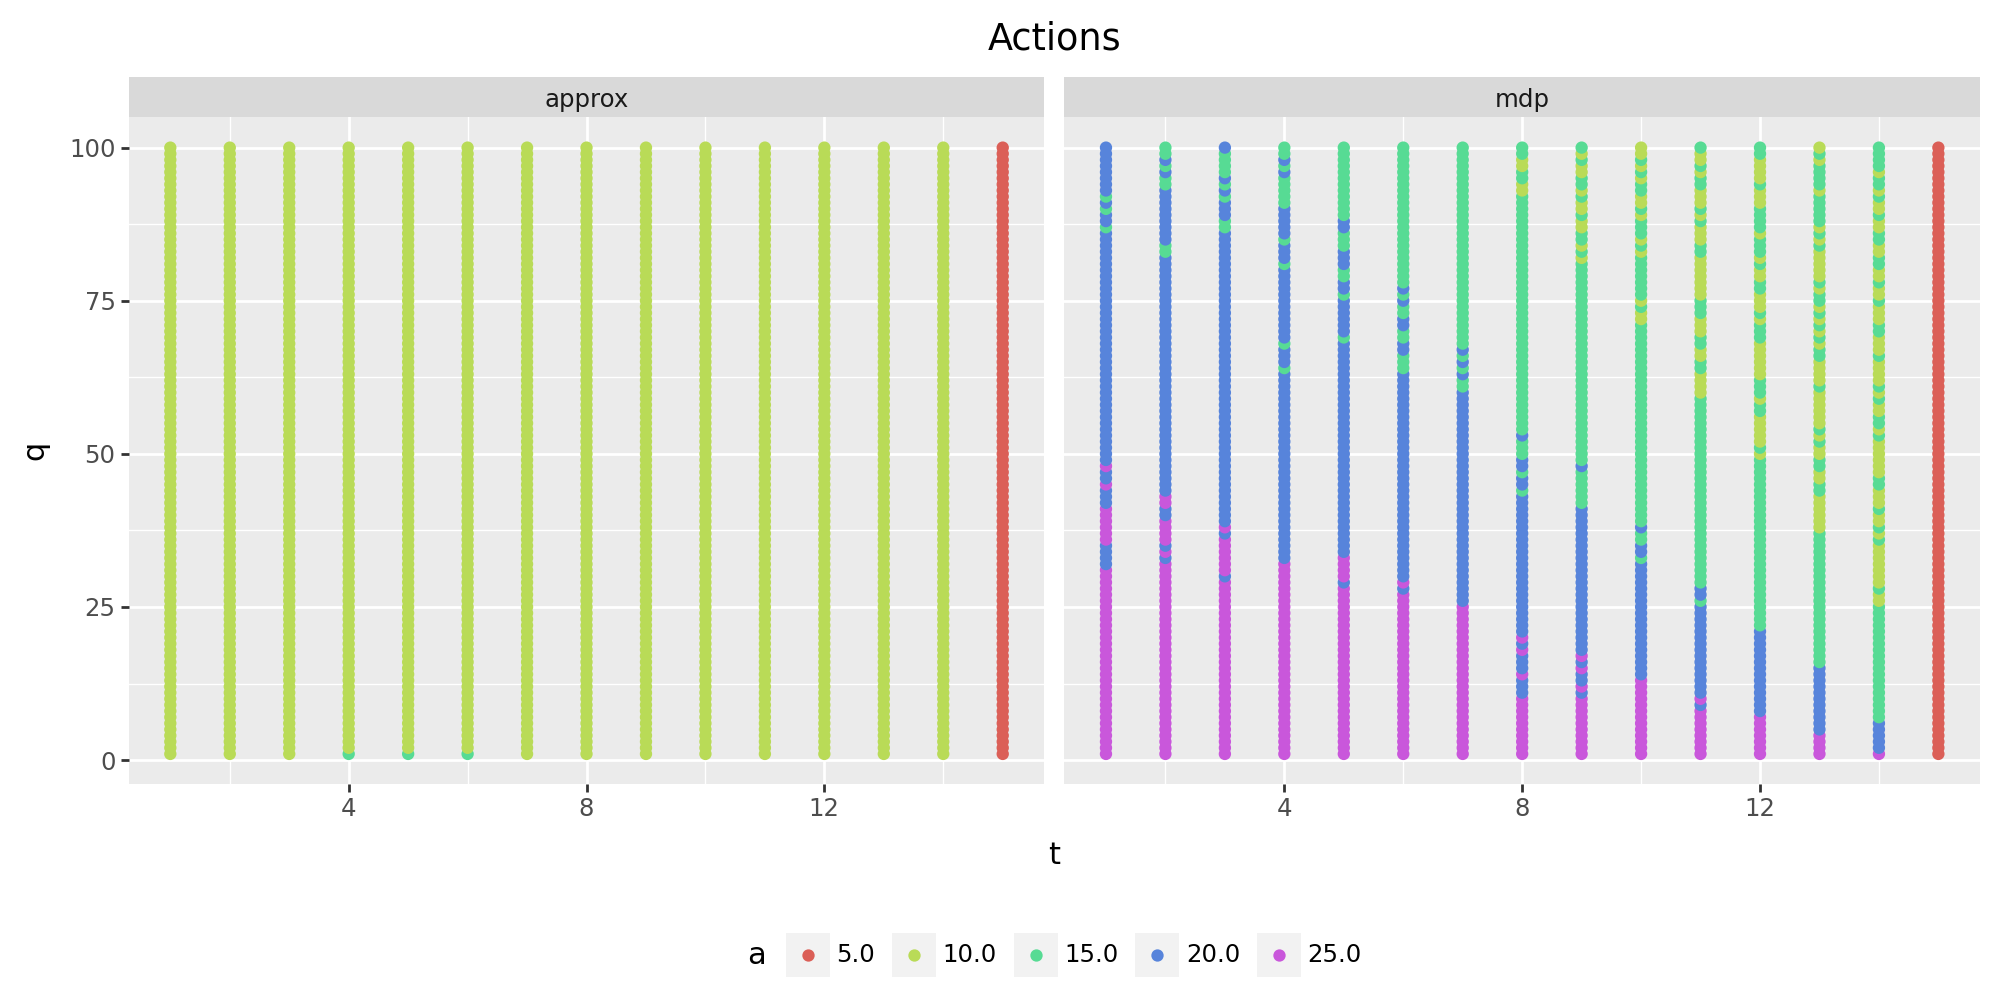

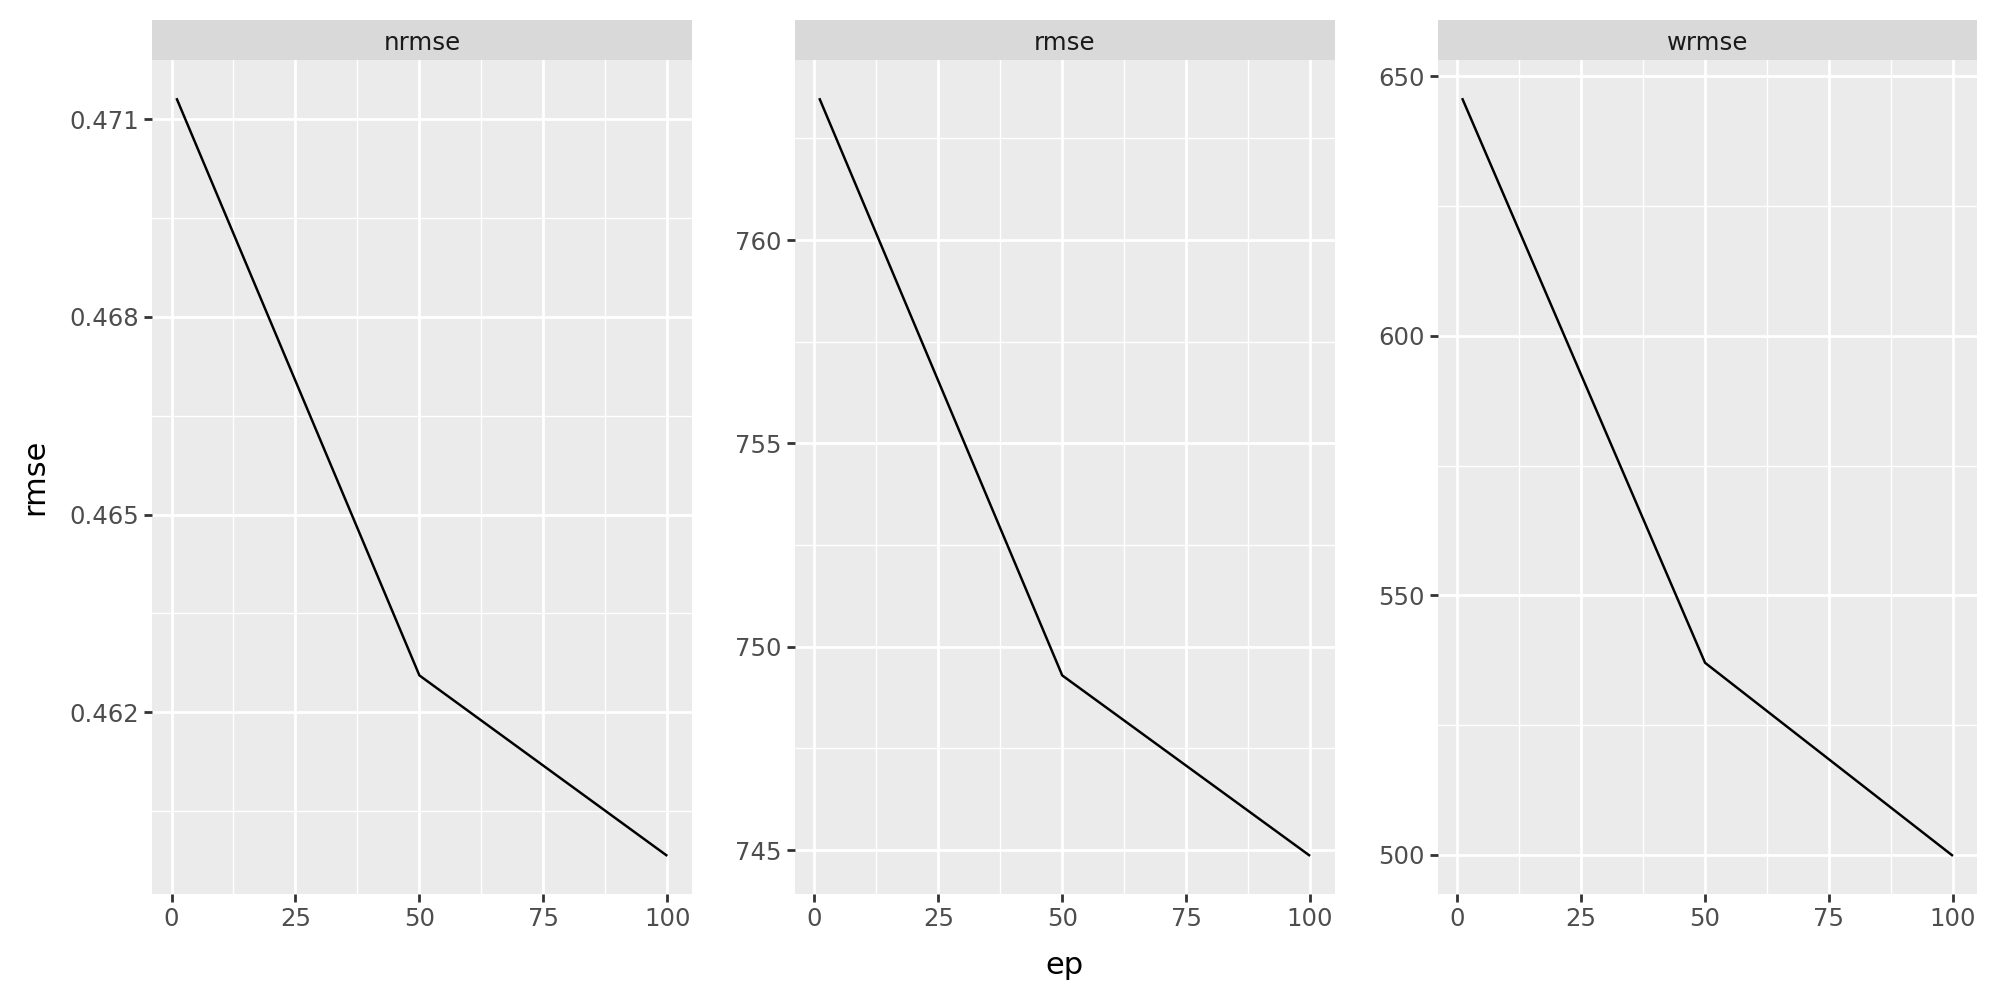

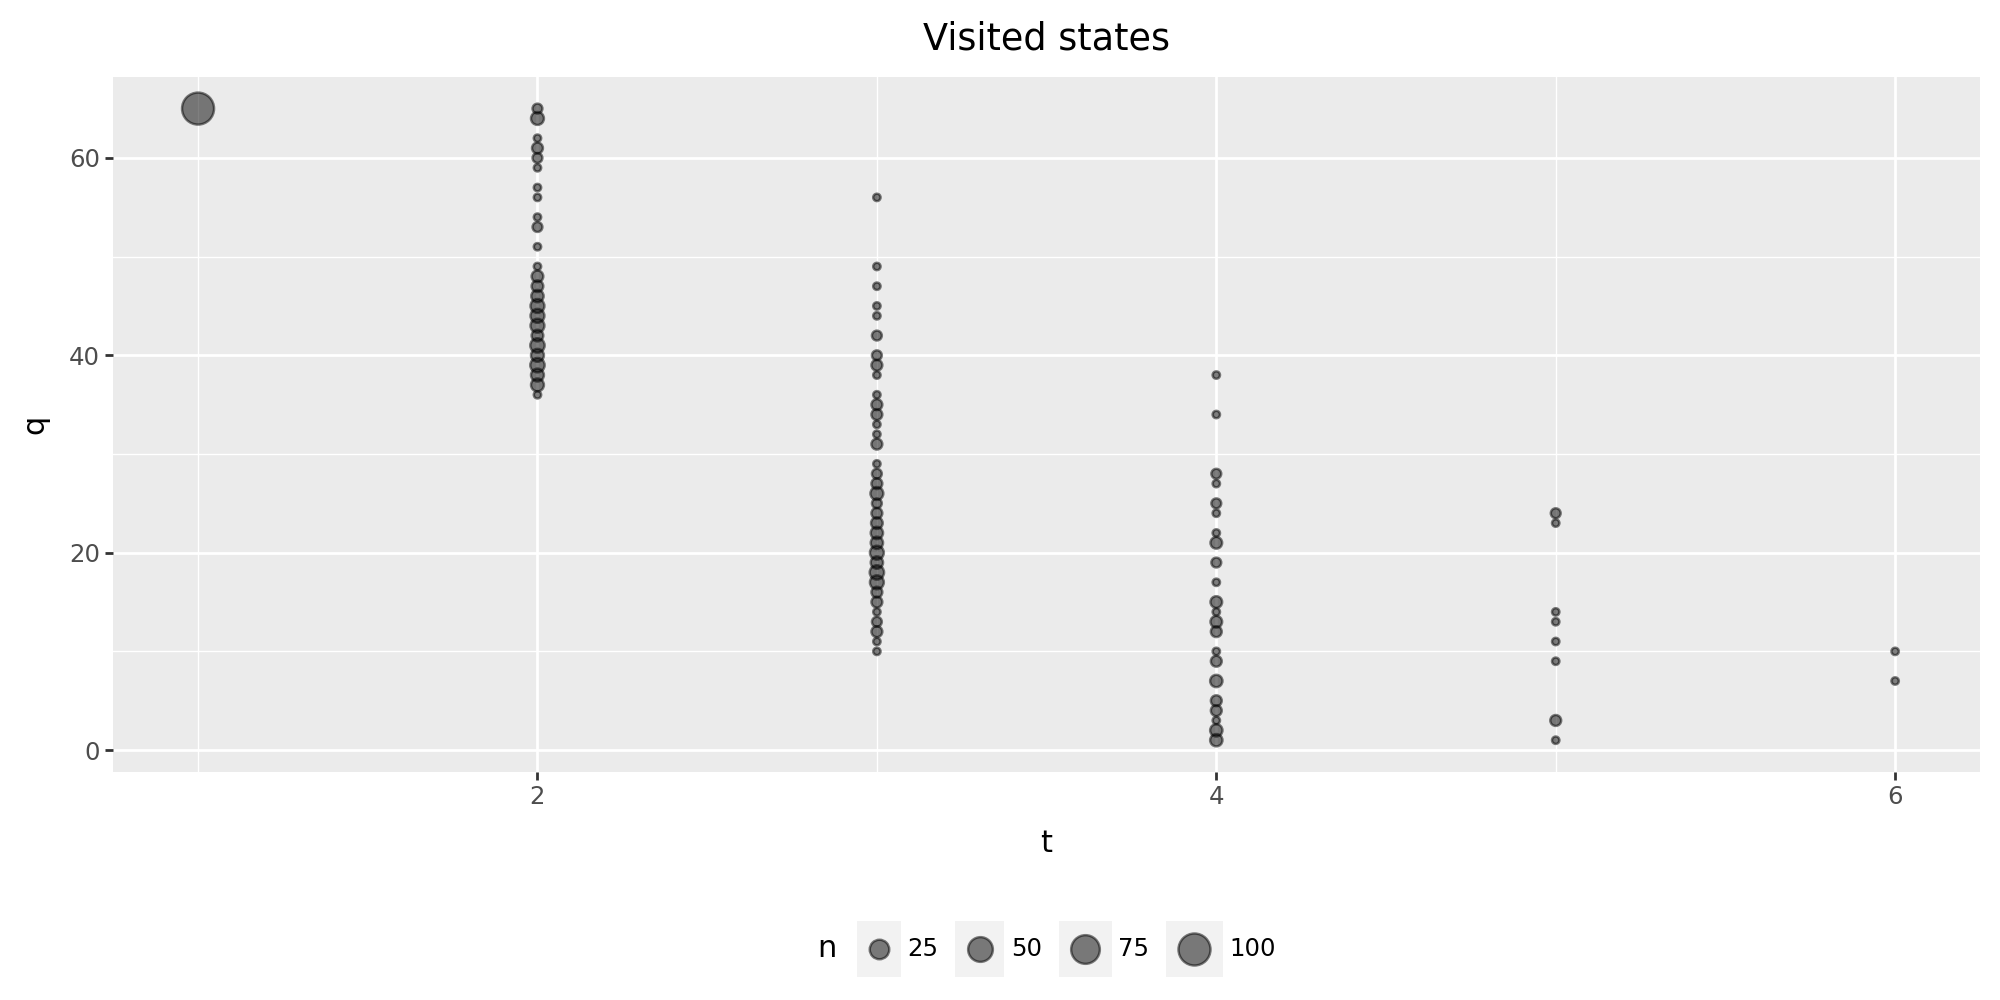

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_point, theme

def plot_trace(trace, dat_mdp):
    """
    Plot the max-Q surface per snapshot in `trace`,
    plus an optional line plot of V(q, t=1) at `start_state`.
    """
    num_3d = len(trace)
    num_plots = num_3d + 1

    # last trace and optimal q-values
    plot_two_snapshots_plotly(trace, dat_mdp, env)

    # last trace and optimal actions
    dat_a = trace[-1]['a'].copy()  # DataFrame with ['q','t','a']
    dat_a['alg'] = 'approx'
    dat_a = dat_a >> bind_rows(dat_mdp >> rename(a = X.action) >> select(~X.v) >> mutate(alg = 'mdp'))
    dat_a['a'] = pd.Categorical(dat_a['a'])
    pt = (
        ggplot(dat_a, aes(x = "t", y = "q", color = "a"))
        + geom_point()
        + facet_wrap('alg')
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(title = "Actions")
    )
    pt.show()

    # RMSEs
    plot_rmse(trace)

    # visited states
    rows, cols = q_hat.s_ctr.shape
    row_indices, col_indices = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    row_indices_flat = row_indices.flatten()
    col_indices_flat = col_indices.flatten()
    flat = q_hat.s_ctr.flatten()
    dat_s = pd.DataFrame({
        'q': row_indices_flat+1,
        't': col_indices_flat+1,
        'n': flat
    })
    dat_s = dat_s >> mask(X.n > 0)
    pt = (
        ggplot(dat_s, aes(x = 't', y = 'q', size = 'n'))
        + geom_point(alpha = 0.5)
        + theme(figure_size=(10,5), legend_position='bottom')
        + labs(title = "Visited states")
    )
    pt.show()

def plot_rmse(trace):
    ep = [t['ep'] for t in trace]
    rmse = [t['rmse'] for t in trace]
    nrmse = [t['nrmse'] for t in trace]
    wrmse = [t['wrmse'] for t in trace]
    dat = pd.DataFrame({'ep': ep, 'rmse': rmse, 'measure': 'rmse'})
    dat = dat >> bind_rows(pd.DataFrame({'ep': ep, 'rmse': nrmse, 'measure': 'nrmse'}))
    dat = dat >> bind_rows(pd.DataFrame({'ep': ep, 'rmse': wrmse, 'measure': 'wrmse'}))
    pt = (
        ggplot(dat, aes(x = 'ep', y = 'rmse'))
        + geom_line()
        + facet_wrap('measure', scales="free")
        + theme(figure_size=(10,5))
    )
    pt.show()


import numpy as np
import plotly.graph_objects as go

def plot_q_3d_plotly(q_arr, env, title="Max Q-value per state"):
    """Interactive 3D surface for max Q-values using Plotly."""
    # Clean up NaNs
    if np.isnan(q_arr).all():
        q_plot = np.zeros_like(q_arr)
    else:
        finite = q_arr[np.isfinite(q_arr)]
        fill = float(finite.min()) if finite.size else 0.0
        q_plot = np.nan_to_num(q_arr, nan=fill)

    x = np.arange(1, env.max_inv + 1)   # inventory
    y = np.arange(1, env.max_t + 1)     # time
    Y, X = np.meshgrid(y, x)

    fig = go.Figure(
        data=[go.Surface(
            x=X, y=Y, z=q_plot,
            colorscale="Viridis",
            colorbar=dict(title="Q"),
            showscale=True,
        )]
    )

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="Inventory (q)",
            yaxis_title="Time (t)",
            zaxis_title="Max Q-value"
        ),
        width=800,
        height=600,
    )
    fig.show()

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

def plot_two_snapshots_plotly(trace, dat_mdp, env, id=-1):
    """
    Plot the a Q-surface of a snapshot in `trace`,
    and the optimal (MDP) Q-surface.
    """
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "surface"}, {"type": "surface"}]],
        subplot_titles=[f"Episode {trace[id]['ep']}", "Optimal (MDP)"]
    )

    # --- Data prep ---
    q_arr = np.nan_to_num(trace[id]['q'])
    tmp = dat_mdp.pivot(index='q', columns='t', values='v').values
    x = np.arange(1, env.max_inv + 1)
    y = np.arange(1, env.max_t + 1)
    Y, X = np.meshgrid(y, x)

    # --- Compute global z-range ---
    zmin = np.nanmin([q_arr.min(), tmp.min()])
    zmax = np.nanmax([q_arr.max(), tmp.max()])

    # --- Surfaces ---
    fig.add_trace(
        go.Surface(x=X, y=Y, z=q_arr, colorscale="Viridis",
                   cmin=zmin, cmax=zmax, showscale=False),
        row=1, col=1
    )
    fig.add_trace(
        go.Surface(x=X, y=Y, z=tmp, colorscale="Viridis",
                   cmin=zmin, cmax=zmax, showscale=True, colorbar_title="Value"),
        row=1, col=2
    )

    # --- Layout with shared z-axis range ---
    fig.update_layout(
        width=1100, height=500,
        scene=dict(
            xaxis_title="Inventory (q)",
            yaxis_title="Time (t)",
            zaxis_title="Value",
            zaxis=dict(range=[zmin, zmax])
        ),
        scene2=dict(
            xaxis_title="Inventory (q)",
            yaxis_title="Time (t)",
            zaxis_title="Value",
            zaxis=dict(range=[zmin, zmax])
        ),
    )

    fig.show()

plot_trace(trace, dat_mdp)


#### Your turn

Explain what is plotted.

* Top left 3D plot is the value function
* Actions table to the left, does not look like the optimal mdp on the right at all (so approximation is quite poor)

Let us put all the code into a singe code cell:

Episode: 100%|██████████| 5000/5000 [00:24<00:00, 205.04episode/s]


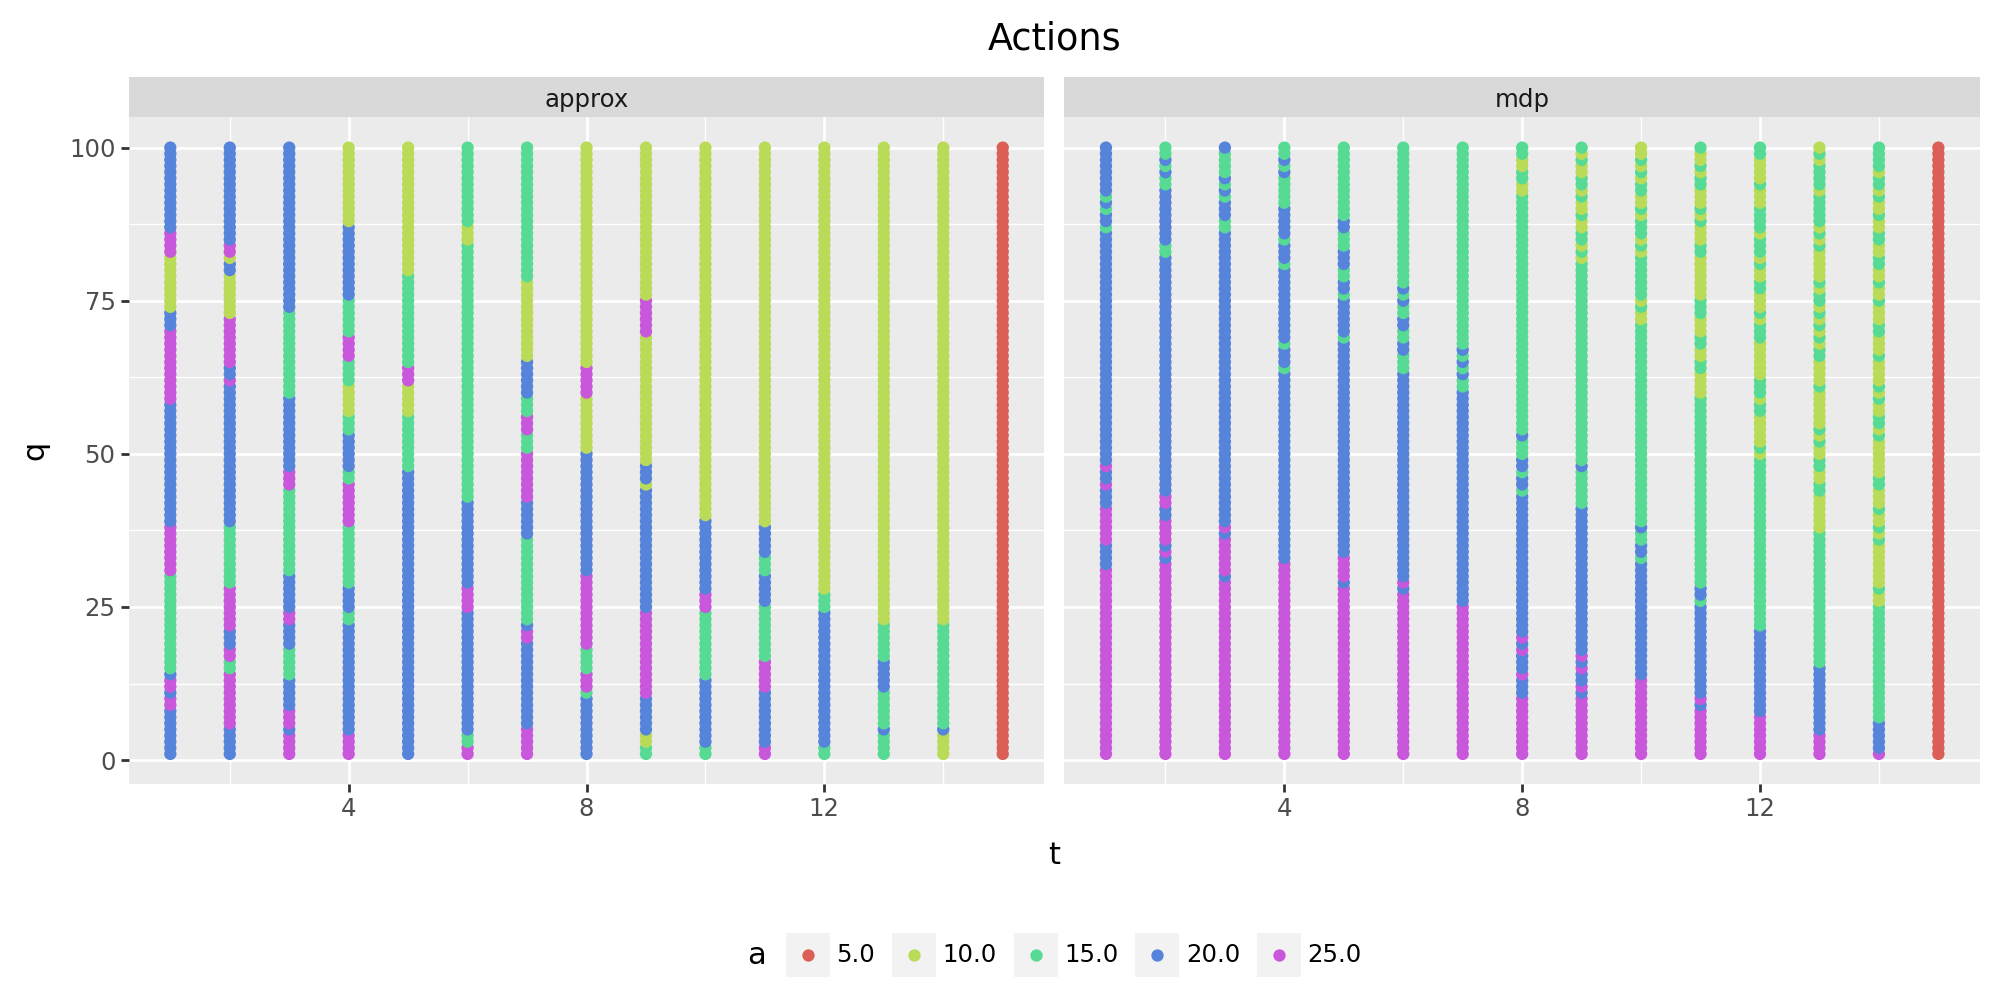

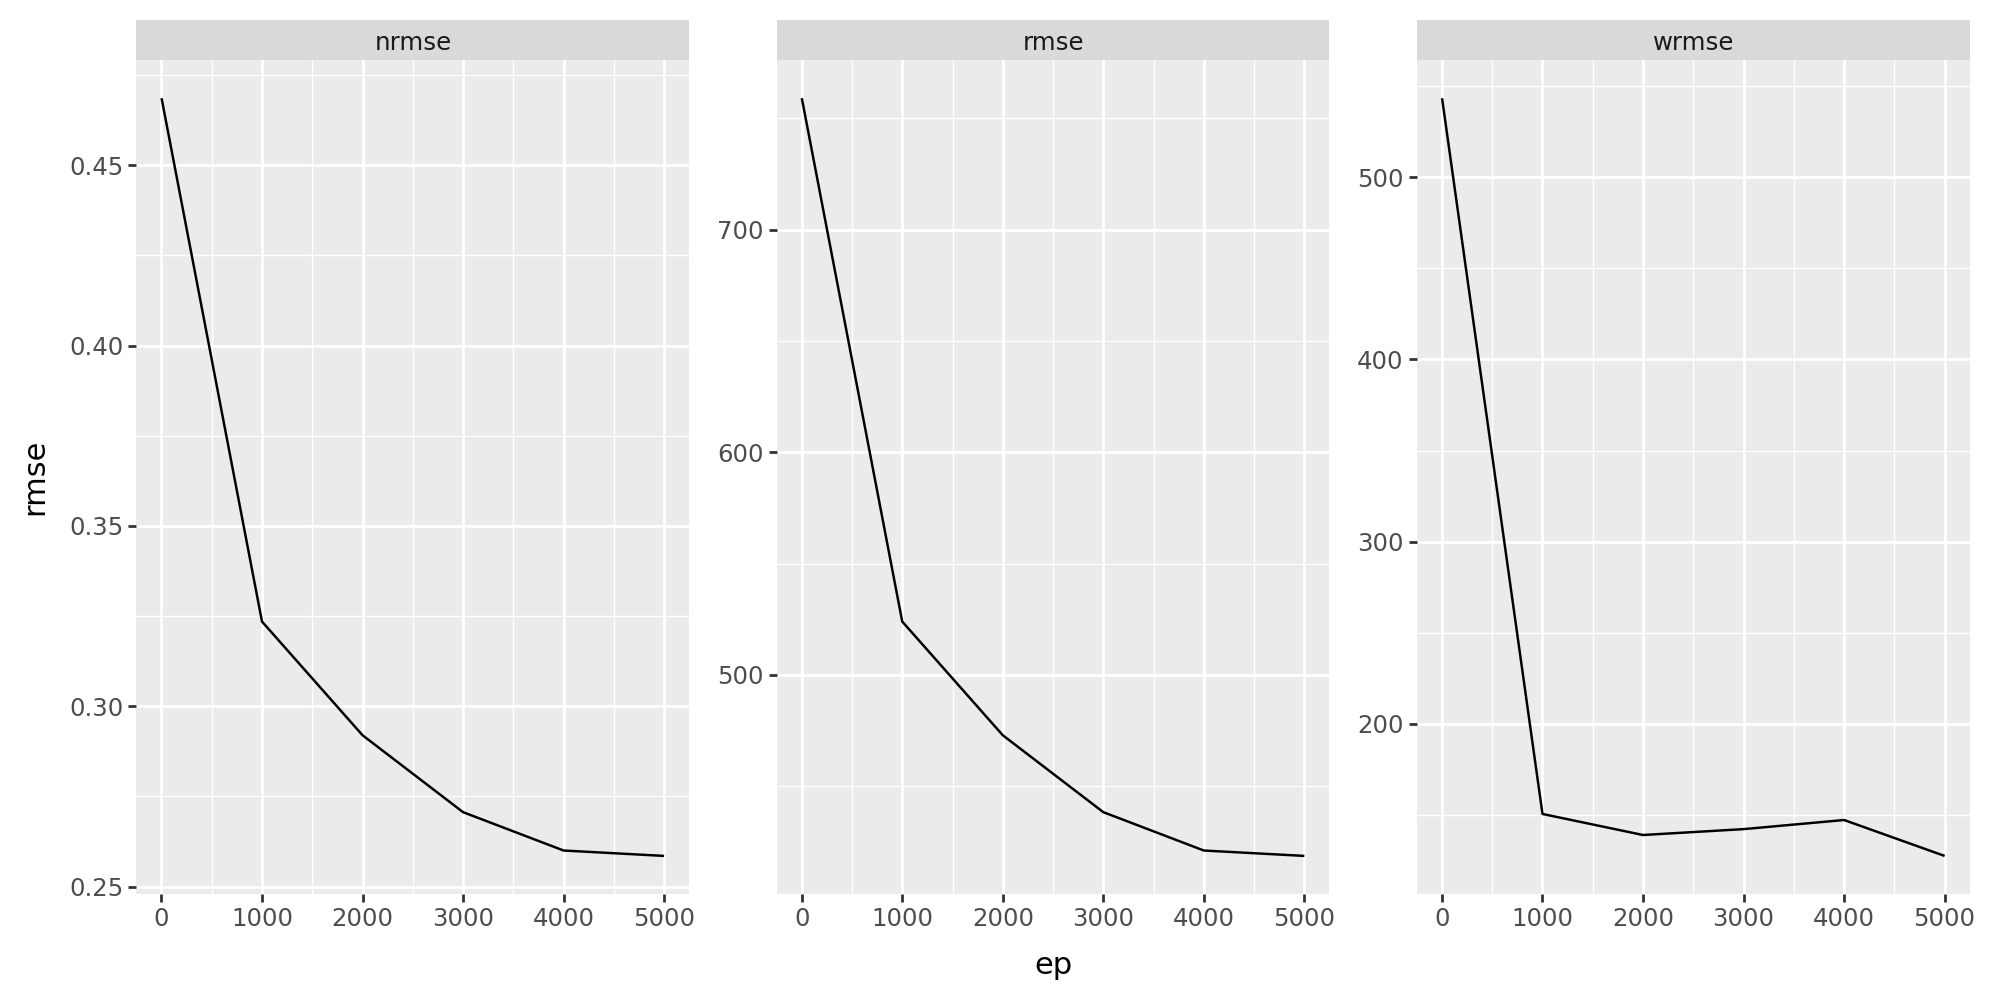

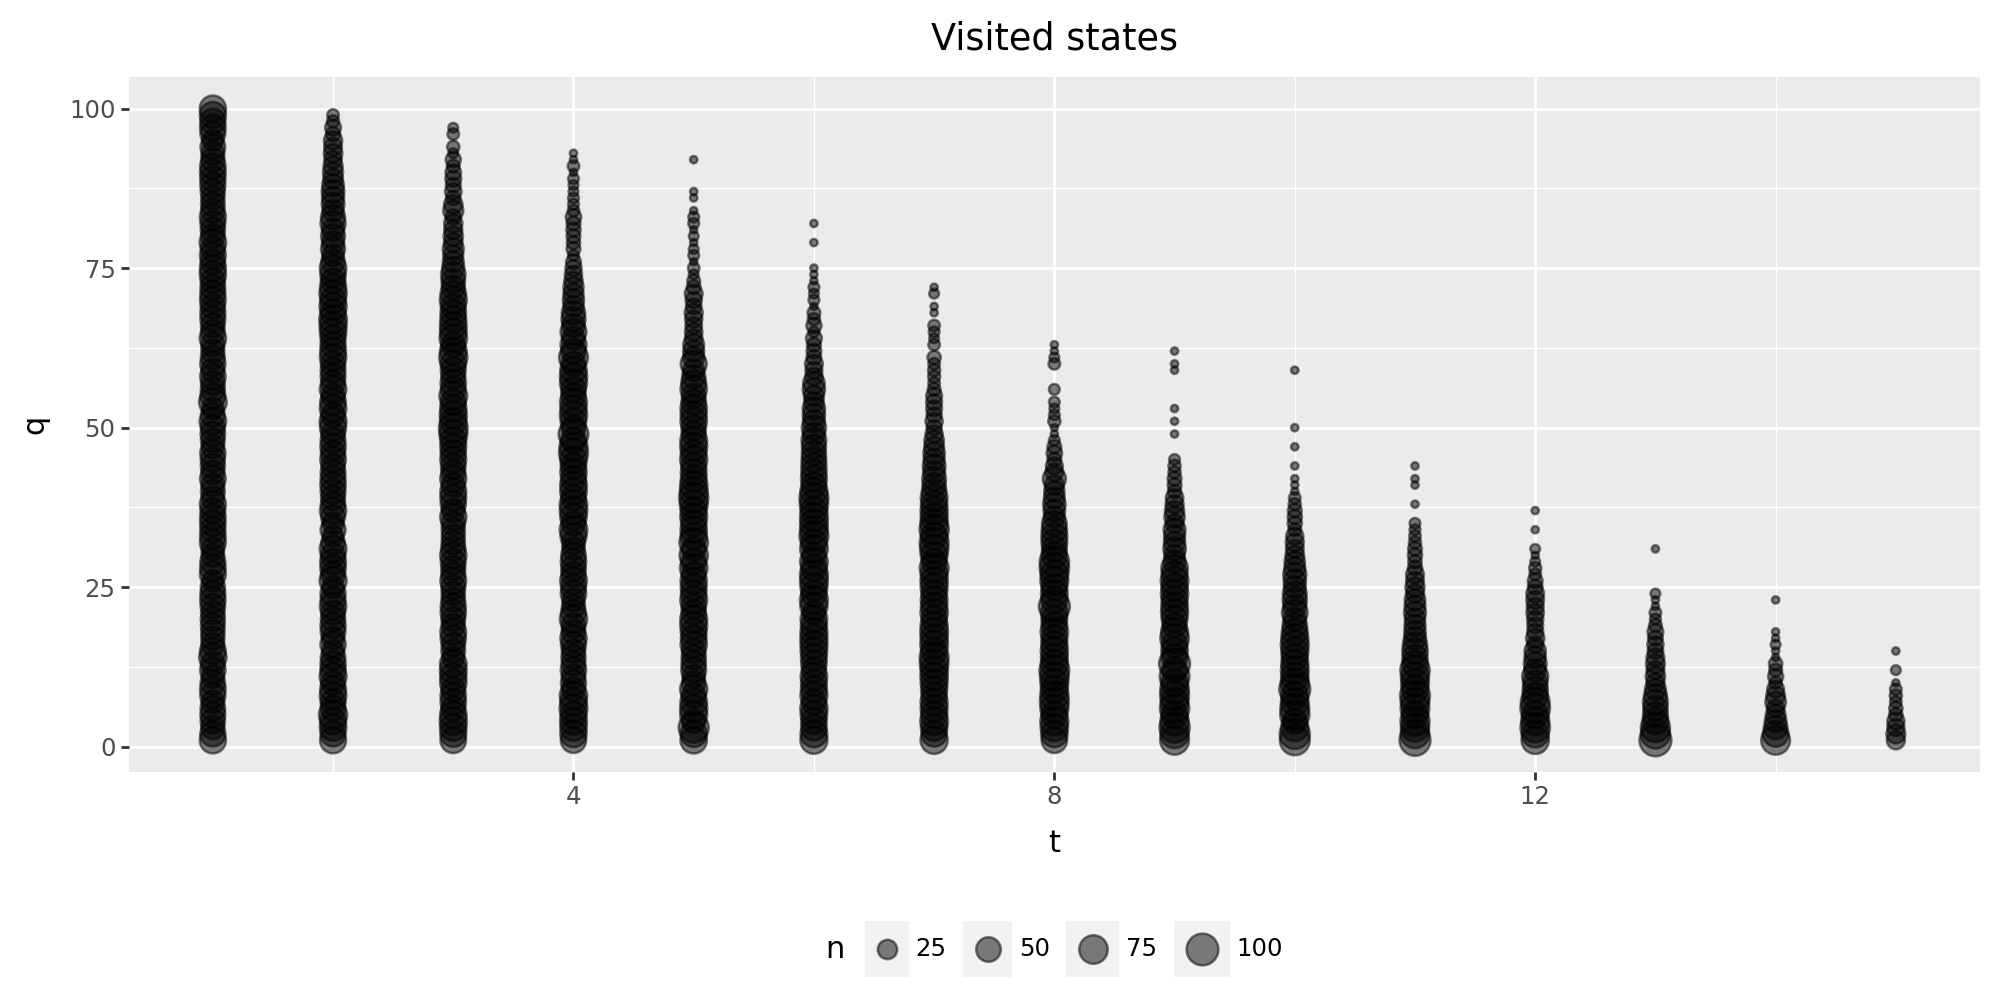

In [12]:
# define candidate sale prices
prices = [10, 15, 20, 25]

# instantiate environment
env = RLEnvSeasonal(
    max_inv=100,       # maximum inventory
    max_t=15,          # selling horizon (weeks)
    scrap_price=5.0,   # scrap value at final week
    purchase_price=14.0,  # cost of each unit purchased at t=1
    prices=prices,      # allowable selling prices
    seed=876
)

# define function approx (step_size will be 0.4/nb_tilings)
q_hat = FuncApproxTiles(env, actions=prices, step_size=1, nb_tilings=8, nb_tiles=8, init_val=0, deterministic=True, seed=53487)

def callback1(ep, func_approx, trace, info, eval_every=1000):
    callback(ep, func_approx, trace, info, eval_every)

# train
q_hat.reset_s_ctr()
q_hat.reset()
trace = []
ep_semi_grad_sarsa(
    env, episodes=5000, gamma=1.0, eps=0.3, q_hat=q_hat,
    # s_start=[start_state],
    callback=callback1, trace=trace,
    max_steps=env.max_t,        # harmless safety
    # eps_decay=decay_factor(0.00000000001, 0.3, 5000)
)

# plot results
plot_trace(trace, dat_mdp)

* After 5000 episodes, we are starting to see the approximation getting closer to the true value

#### Your turn

Explain the output.

- How good are our state-value estimates compared to optimal?

  *Your comments*

- How good are our action estimates compared to optimal?

  *Your comments*

- Do we visit all states during sampling?

  *Your comments*
  
- How could we change the algorithm so visit more states during sampling?

  *Your comments*

- Which policy have we tried to find estimates for?

  *Your comments*

#### Your turn

Could other starting estimates of the q-values be useful? Test by running the code with your choice.   

Episode: 100%|██████████| 5000/5000 [00:30<00:00, 163.12episode/s]


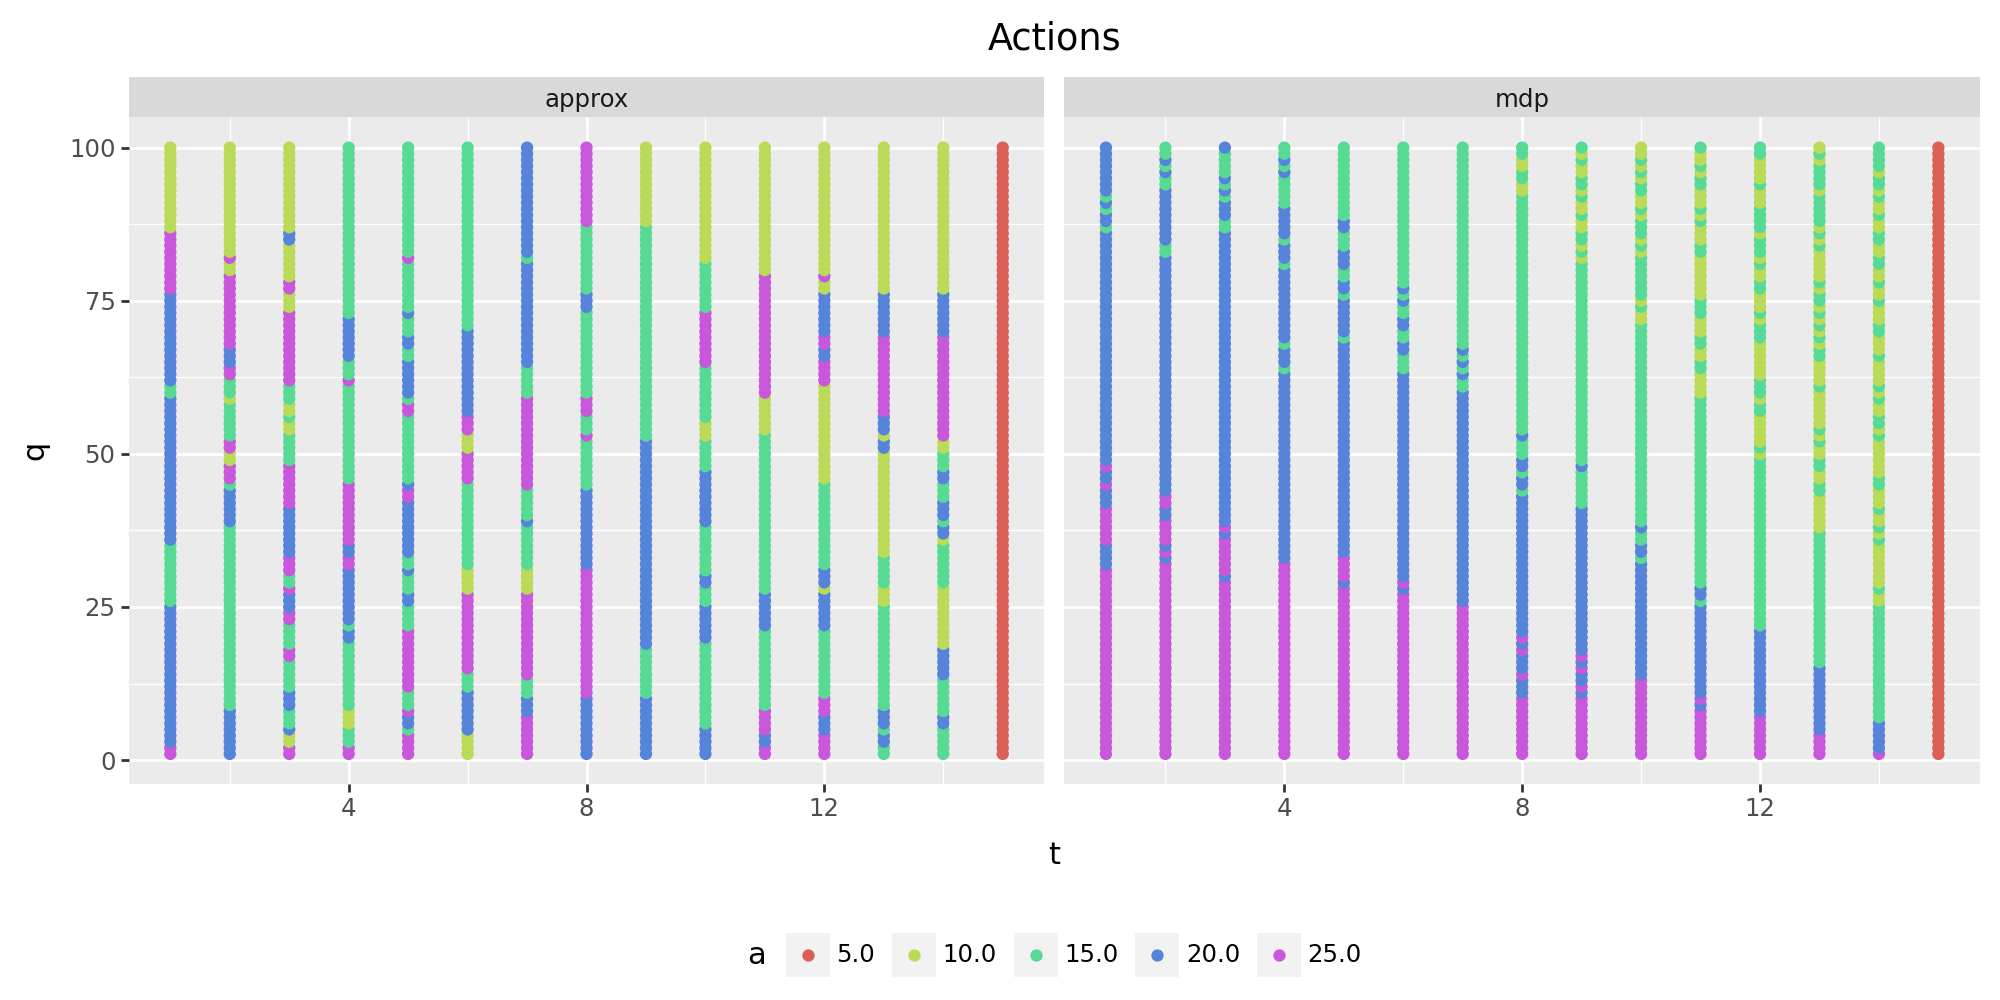

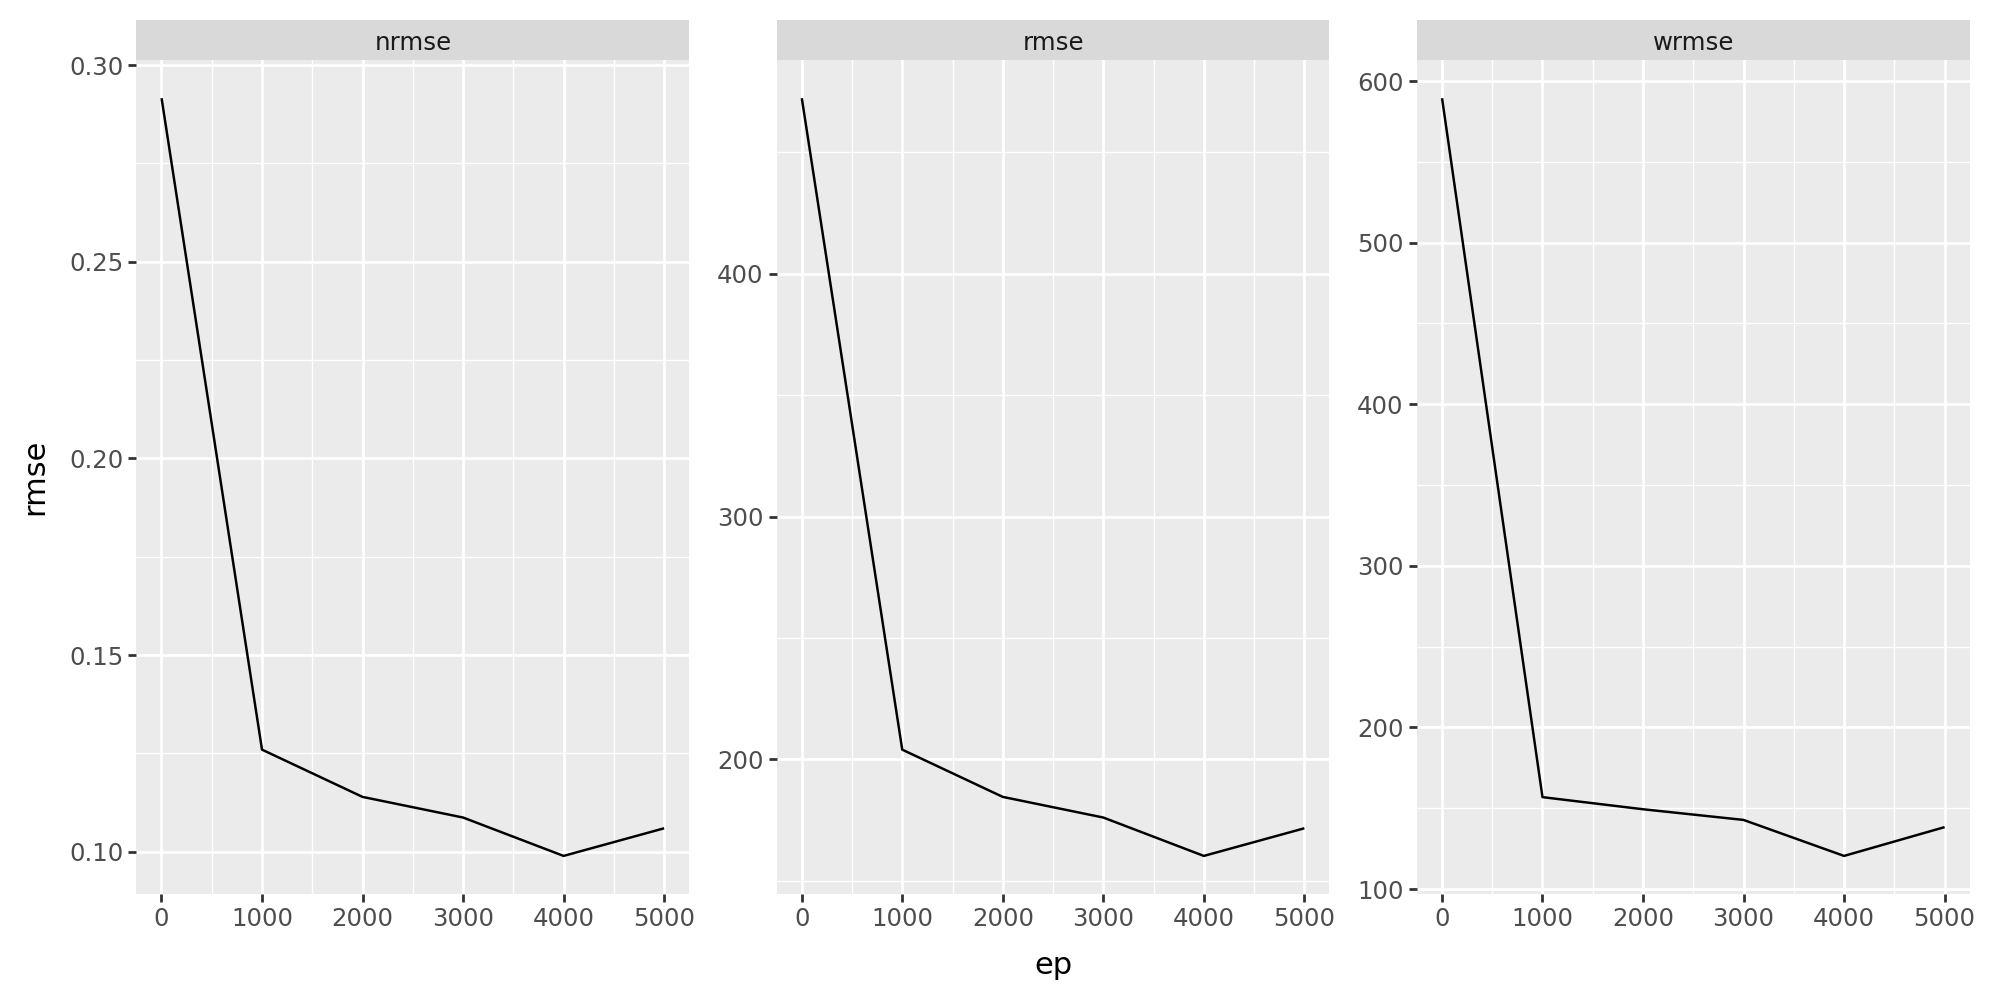

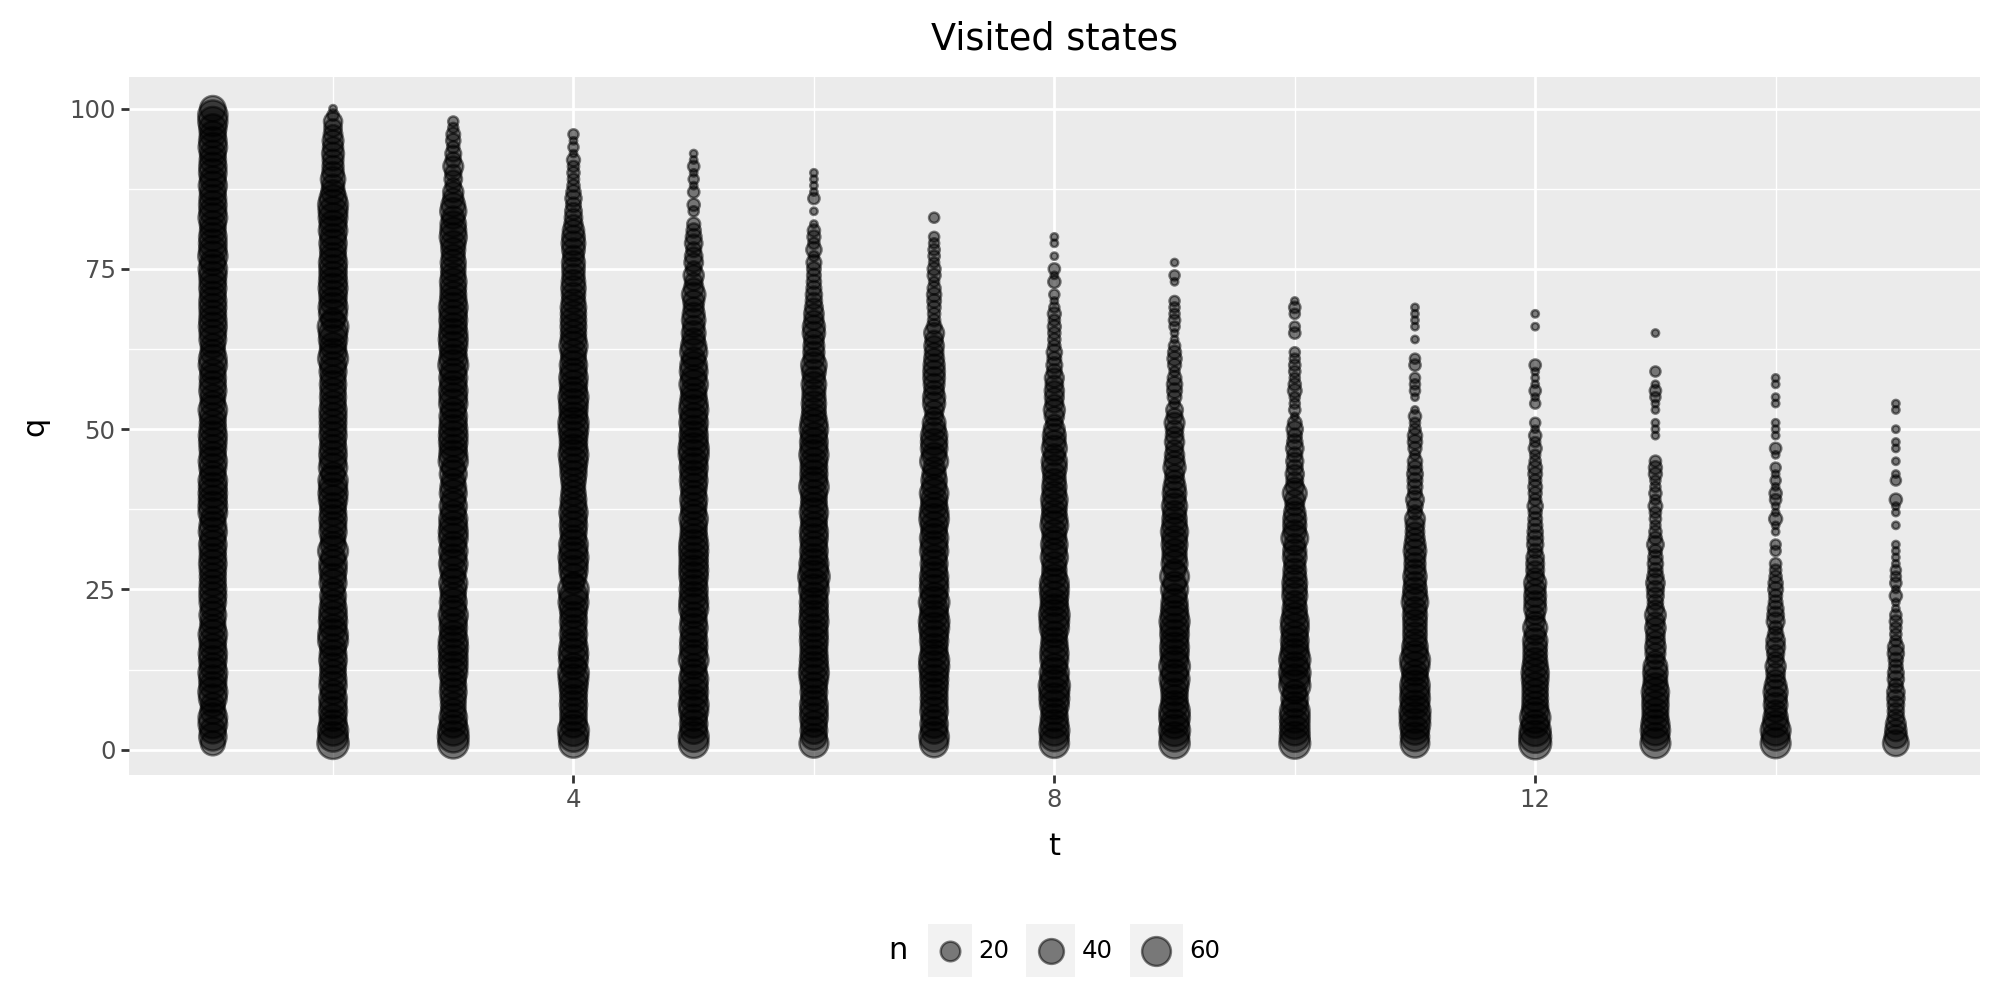


Your comments


In [14]:
#@title Solution
# define candidate sale prices
prices = [10, 15, 20, 25]

# instantiate environment
env = RLEnvSeasonal(
    max_inv=100,       # maximum inventory
    max_t=15,          # selling horizon (weeks)
    scrap_price=5.0,   # scrap value at final week
    purchase_price=14.0,  # cost of each unit purchased at t=1
    prices=prices,      # allowable selling prices
    seed=876
)

# define function approx (step_size will be 0.4/nb_tilings)
q_hat = FuncApproxTiles(env, actions=prices, step_size=1, nb_tilings=8, nb_tiles=8, init_val=900, deterministic=True, seed=53487)

def callback1(ep, func_approx, trace, info, eval_every=1000):
    callback(ep, func_approx, trace, info, eval_every)

# train
q_hat.reset_s_ctr()
q_hat.reset()
trace = []
ep_semi_grad_sarsa(
    env, episodes=5000, gamma=1.0, eps=0.3, q_hat=q_hat,
    # s_start=[start_state],
    callback=callback1, trace=trace,
    max_steps=env.max_t,        # harmless safety
    # eps_decay=decay_factor(0.00000000001, 0.3, 5000)
)

# plot results
plot_trace(trace, dat_mdp)

display(Markdown("""
Your comments
"""))

* We tried to set the initial value to a place around the middle of the 3D chart in the top right (in this case we tried 900)
* We can tell from the 3D chart top left, that there's a lot of states we haven't visited which all start at 900 now instead of 0 like previously
* There are still a lot of states (see bottom chart top right corner is blank) that we haven't visited

Currently, we estimate the eps-soft policy. However, we may use a decay to let epsilon (exploration) decrease over the episodes.

In [16]:
def decay_factor(goal_eps, start_eps, ep):
    """
    Decay function for epsilon.

    Args:
        goal_eps (float): Final epsilon value wanted in the last episode.
        start_eps (float): Initial epsilon value.
        ep (int): Total number of episodes.

    Returns:
        decay factor to use to get to goal_eps in ep steps.
    """
    return (goal_eps/start_eps)**(1/ep)


#### Your turn

Use the decay function to set factor that must be used as argument `eps_decay` to `ep_semi_grad_sarsa`. Note you may here start with a high epsilon and set it to decay to e.g. 0.0001 in the end.

- Did your results improve?

Episode: 100%|██████████| 5000/5000 [00:37<00:00, 133.65episode/s]


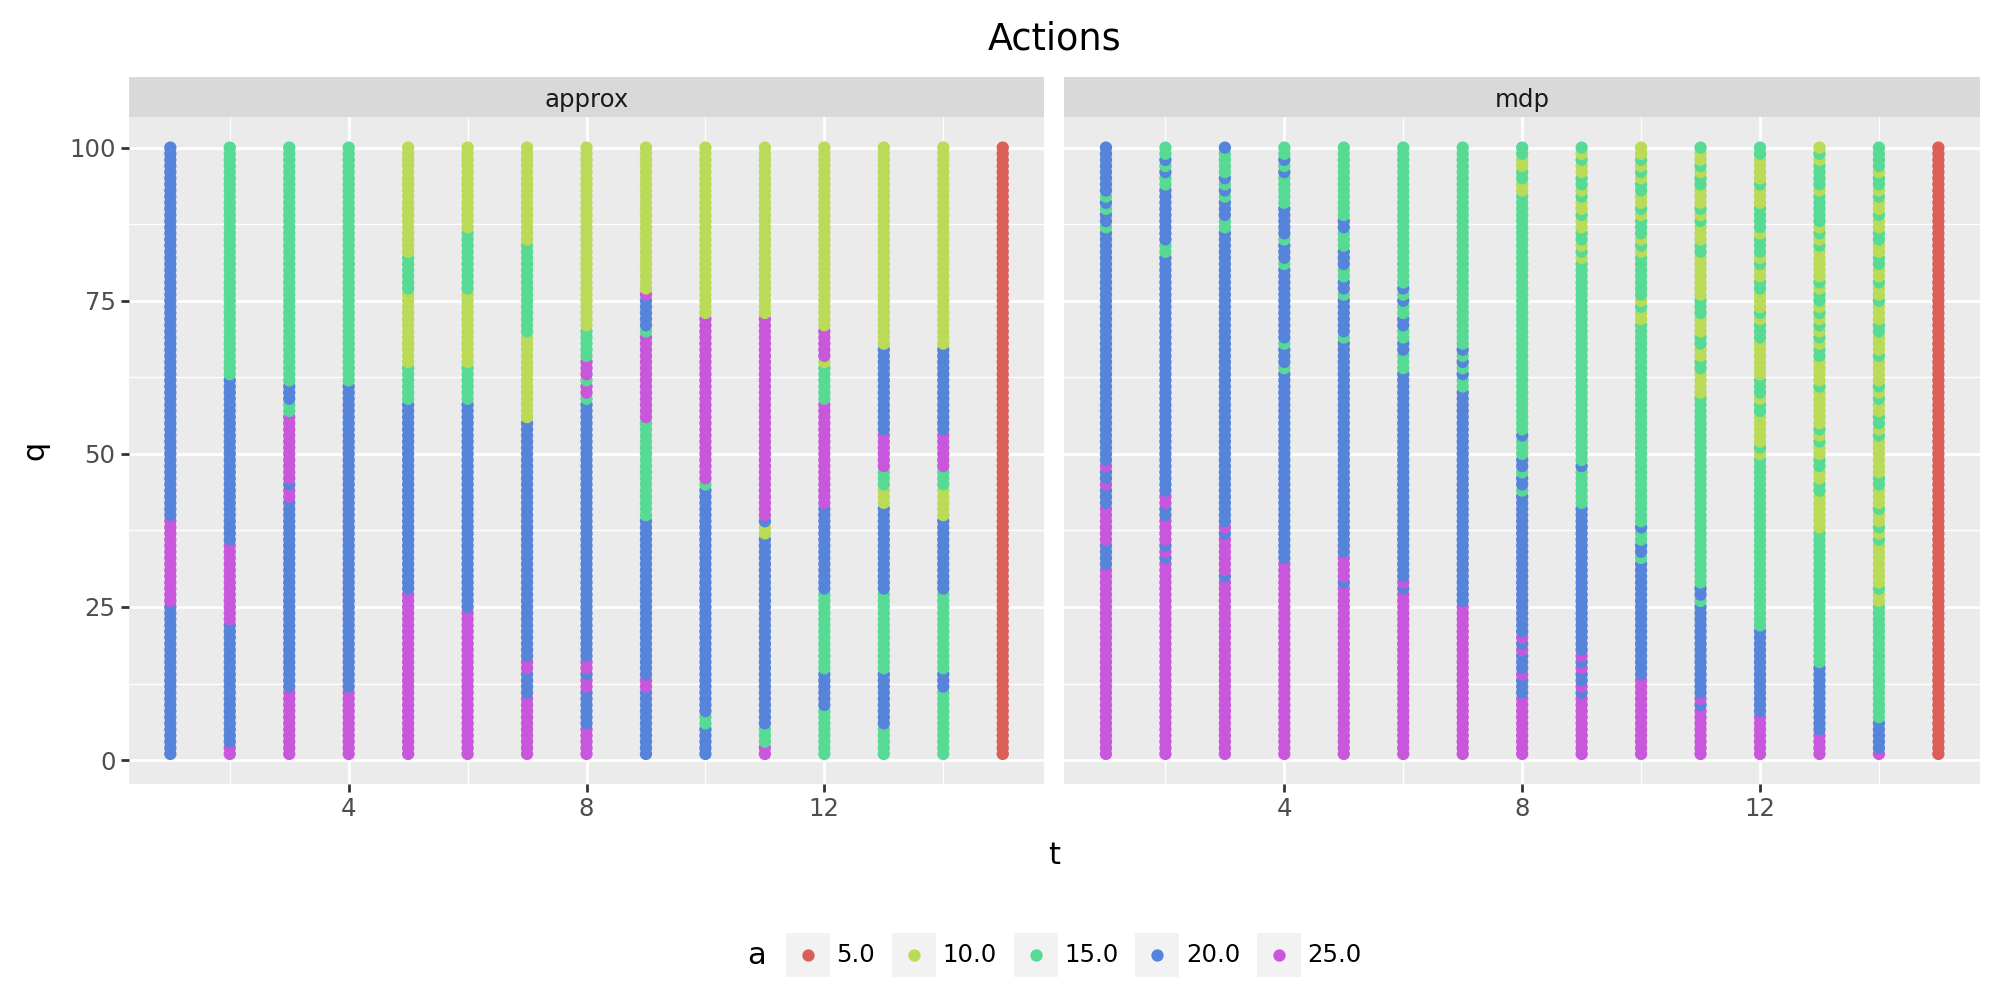

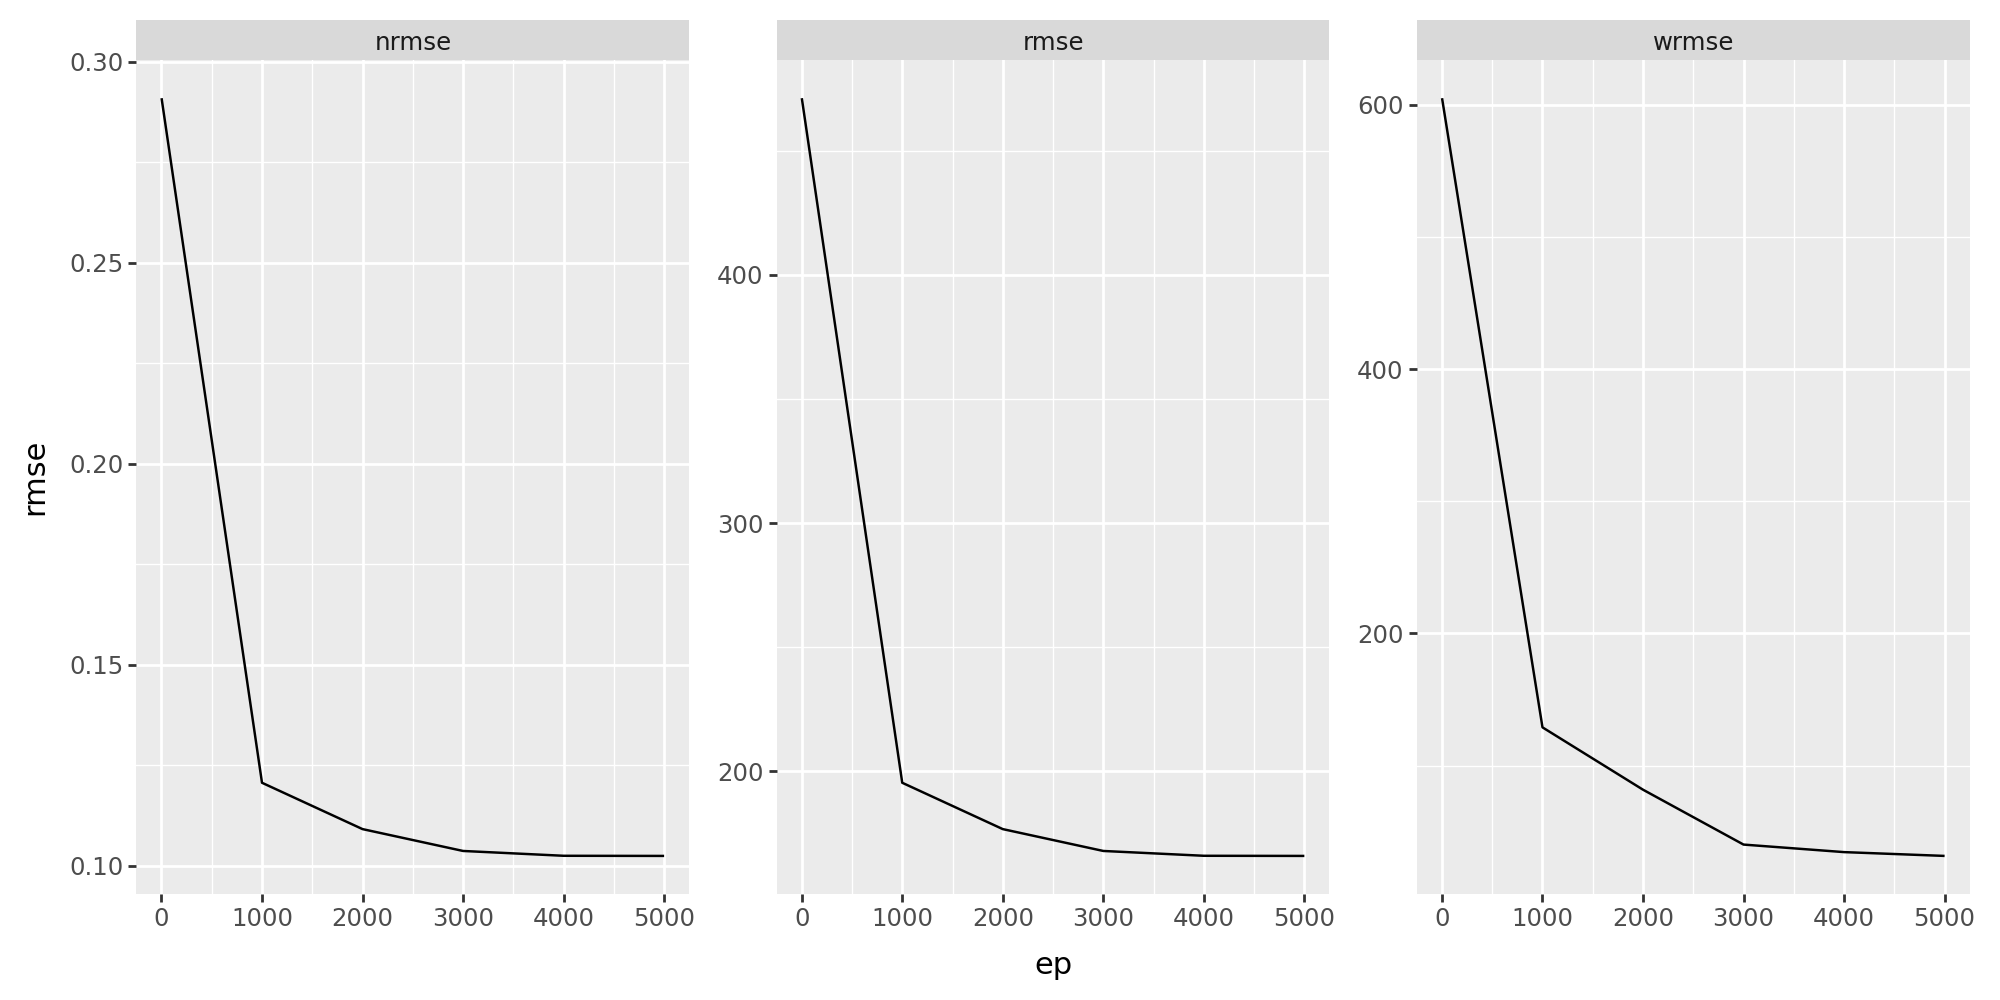

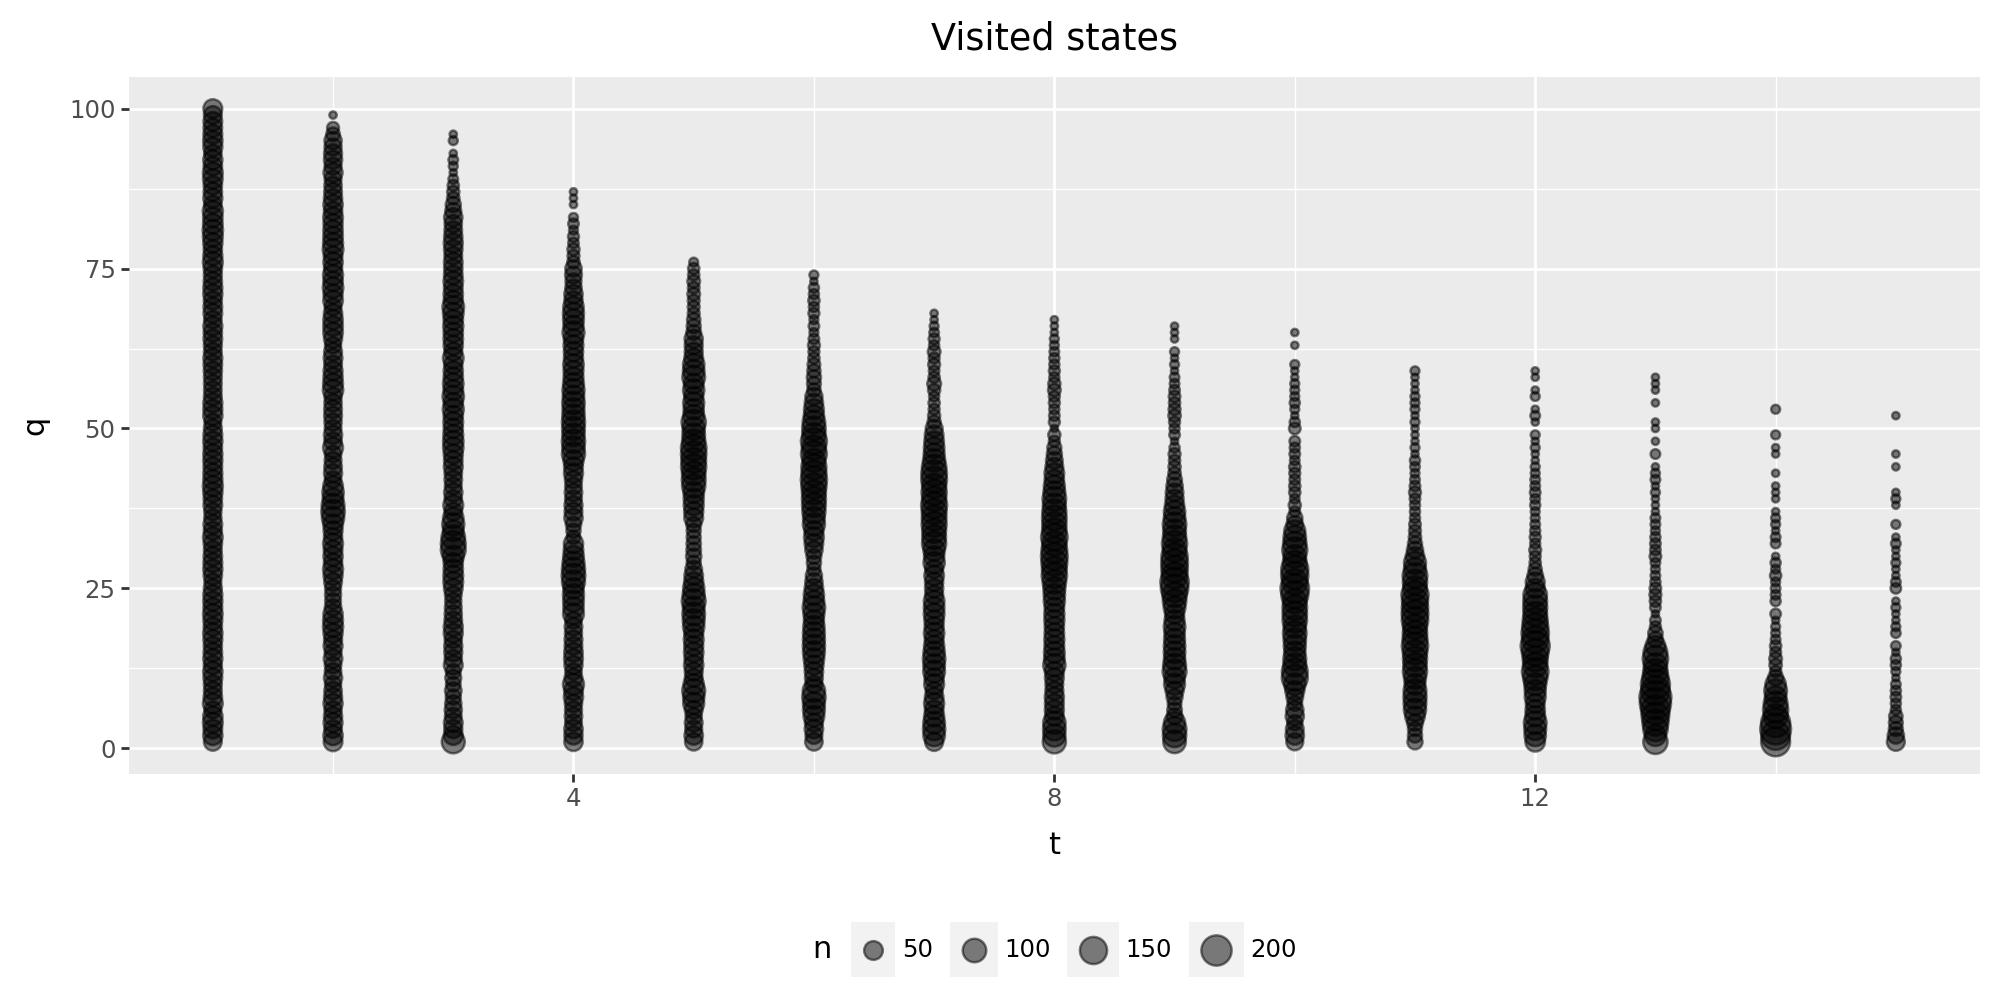

In [17]:
#@title Solution
# define candidate sale prices
prices = [10, 15, 20, 25]

# instantiate environment
env = RLEnvSeasonal(
    max_inv=100,       # maximum inventory
    max_t=15,          # selling horizon (weeks)
    scrap_price=5.0,   # scrap value at final week
    purchase_price=14.0,  # cost of each unit purchased at t=1
    prices=prices,      # allowable selling prices
    seed=876
)

# define function approx (step_size will be 0.4/nb_tilings)
q_hat = FuncApproxTiles(env, actions=prices, step_size=1, nb_tilings=8, nb_tiles=8, init_val=900, deterministic=True, seed=53487)

def callback1(ep, func_approx, trace, info, eval_every=1000):
    callback(ep, func_approx, trace, info, eval_every)

# train
q_hat.reset_s_ctr()
q_hat.reset()
trace = []
ep_semi_grad_sarsa(
    env, episodes=5000, gamma=1.0, eps=0.3, q_hat=q_hat,
    # s_start=[start_state],
    callback=callback1, trace=trace,
    max_steps=env.max_t,        # harmless safety
    eps_decay=decay_factor(0.0001, 1, 5000)
)

# plot results
plot_trace(trace, dat_mdp)

* What did we figure out here by using the eps_decay?

## Episodic semi-gradient expected SARSA

Using Q-learning may not work since this is an off-policy algorithm, which may diverge due to the “deadly triad” (off-policy + bootstrapping + approximation). This is true even with linear features and fixed $\epsilon$-greedy behavior; there is no general convergence guarantee.

However, we may modify the algorithm to use expected SARSA instead.

In [ ]:
#@title Episodic semi-gradient expected SARSA

def ep_semi_grad_exp_sarsa(
    env,
    episodes,
    gamma,
    eps,
    q_hat,
    s_start=None,
    callback=None,
    trace=None,
    max_steps=None,
    eps_decay=None  # float or callable
):
    """
    Episodic semi-gradient Expected SARSA for RLEnvSeasonal-like env.

    Expects:
      env.reset() -> [q, t]
      env.get_actions(s) -> list of feasible actions
      env.get_step(s, a) -> (s_next, r, done)
      q_hat.eval(s, a) -> float
      q_hat.train(s, a, target) -> None
    """

    def argmax_rand(values):
        m = np.max(values)
        idx = np.flatnonzero(values == m)
        return np.random.choice(idx)

    def eps_greedy_action(s, eps_curr):
        actions = env.get_actions(s)
        if np.random.rand() < eps_curr:
            return float(np.random.choice(actions))
        qvals = np.array([q_hat.eval(s, a) for a in actions], dtype=float)
        return float(actions[argmax_rand(qvals)])

    def expected_q(s, eps_curr):
        """
        E[ Q(s, A) ] where A ~ epsilon-greedy over actions in s.
        """
        actions = env.get_actions(s)
        nA = len(actions)
        qvals = np.array([q_hat.eval(s, a) for a in actions], dtype=float)

        # greedy(s)
        greedy_idx = argmax_rand(qvals)
        greedy_q = qvals[greedy_idx]

        # prob of each action under epsilon-greedy
        # P(a) = eps/nA for all a, plus (1-eps) for greedy
        base_p = eps_curr / nA
        probs = np.full(nA, base_p, dtype=float)
        probs[greedy_idx] += (1.0 - eps_curr)

        # expected Q
        return float(np.dot(probs, qvals))

    def pick_start():
        if s_start is None:
            return env.reset()
        try:
            if isinstance(s_start, (str, bytes)):
                return s_start
            return list(s_start)[np.random.randint(len(s_start))]
        except TypeError:
            return s_start

    eps_curr = float(eps)

    for ep in tqdm(range(1, episodes + 1), desc="Episode", unit="episode",
                   bar_format='{l_bar}{bar}| {n}/{total} [{elapsed}<{remaining}, {rate_fmt}{postfix}]'):
        s = pick_start()
        a = eps_greedy_action(s, eps_curr)
        steps = 0

        while True:
            s_n, r, done = env.get_step(s, a)

            if done:
                # terminal target
                q_hat.train(s, a, r)
                break
            else:
                # Expected SARSA target
                exp_q_next = expected_q(s_n, eps_curr)
                target = r + gamma * exp_q_next
                q_hat.train(s, a, target)

                # next behavior action (still epsilon-greedy)
                s, a = s_n, eps_greedy_action(s_n, eps_curr)

            steps += 1
            if max_steps is not None and steps >= max_steps:
                break

        # callback at the end of the episode
        if callback is not None:
            info = {"epsilon": eps_curr, "steps": steps}
            callback(ep, q_hat, trace, info)

        # optional epsilon schedule
        if eps_decay is not None:
            if callable(eps_decay):
                eps_curr = float(eps_decay(ep, eps_curr))
            else:
                eps_curr = eps_curr * float(eps_decay)
            eps_curr = min(1.0, max(0.0, eps_curr))


#### Your turn

- Run exp SARSA with your preferred parameters.
- Are your results better?


In [ ]:
#@title Solution

env.reset_rng()

start_alph = 1/8  # overall alpha / nb tilings
goal_alph = 0.01
visits = 300  # approx max number of visits per state
q_hat = FuncApproxTiles(
    env, actions=prices,
    step_size=1,
    nb_tilings=8, nb_tiles=8, init_val=900,
    deterministic=True,
    decay_fct=decay_factor(goal_alph, start_alph, visits)
)

# train
trace = []
start_eps = 1
goal_eps = 0.0001
episodes = 5000
# Your code

# plot results
plot_trace(trace, dat_mdp)

display(Markdown("""
Your comments
"""))

NameError: name 'decay_factor' is not defined

## Exercises

### Exercise (seasonal inventory)

Solve the seasonal inventory and sales planning problem in Example 9.4.4.

Use a Fourier basis as function approximation to estimate the action-values.

In [ ]:
#@title Solution

# Your code

display(Markdown("""
Your comments
"""))


Your comments


### Exercise (car rental)

Consider the [Car rental problem](https://bss-osca.github.io/rl/07_mdp-2.html#sec-mdp-2-car). Our goad is to use function approximation to estimate the optimal state value function.

An environment is given below.

In [ ]:
#@title Car rental environment

import numpy as np
from typing import Callable, Tuple, List, Dict


class RLEnvCar:
    """
    Car rental environment (two locations) with Poisson demand/returns.

    States are tuples (x, y) with x,y ∈ {0..20}.
    """

    def __init__(self,
                 lD: List[float] = [3, 4],
                 lH: List[float] = [3, 2],
                 seed: int | None = None):
        self.lD = list(lD)
        self.lH = list(lH)
        self.rng = np.random.default_rng(seed)
        self.cars_max = 20  # max number of cars at each location

    def reset(self):
        """Reset the environment."""
        return (10, 10)

    # ------------------------------------------------------------------

    def get_states(self) -> List[Tuple[int, int]]:
        """Return all possible states as (x, y) tuples."""
        return [(x, y) for x in range(21) for y in range(21)]

    def get_actions(self, s: Tuple[int, int]) -> List[int]:
        """Return feasible integer actions for state (x, y)."""
        x, y = s
        low = -min(5, y, 20 - x)
        high = min(5, x, 20 - y)
        return list(range(low, high + 1))

    def get_step(self, s: Tuple[int, int], a: int) -> Dict[str, float | Tuple[int, int]]:
        """
        Take one step in the environment.

        Args:
            s: Current state (x, y)
            a: Action, cars moved from 1→2 (negative = 2→1)

        Returns:
            tuple (next_state, reward).
        """
        x, y = s
        low = -min(5, y, 20 - x)
        high = min(5, x, 20 - y)

        if not (low <= a <= high):
            raise ValueError(f"Action {a} not feasible in state {s}")

        # Apply overnight move
        x_bar = x - a
        y_bar = y + a

        # Demand and returns
        d_x = int(self.rng.poisson(self.lD[0]))
        d_y = int(self.rng.poisson(self.lD[1]))
        h_x = int(self.rng.poisson(self.lH[0]))
        h_y = int(self.rng.poisson(self.lH[1]))

        # Rentals served
        served_x = min(d_x, x_bar)
        served_y = min(d_y, y_bar)

        # Next state (capped)
        x_next = min(20, x_bar - served_x + h_x)
        y_next = min(20, y_bar - served_y + h_y)

        reward = 10.0 * (served_x + served_y) - 2.0 * abs(a)

        return (x_next, y_next), float(reward)


Let us create an instance of the environment:

In [ ]:
env = RLEnvCar(seed=42)
print(env.get_step((10, 10), 3))

((7, 9), 84.0)


#### Q1

What is the return output of method `get_step`?

*Your comment*

#### Differential (average-reward) semi-gradient Expected SARSA

To do function approximation, we modify the episodic expected SARSA version to a continuous task version:

In [ ]:
#@title Differential (average-reward) semi-gradient Expected SARSA

import numpy as np
from typing import Any, Callable, Optional, Tuple, Dict

def cont_diff_expected_sarsa(
    env: Any,
    total_steps: int,
    beta: float,
    eps: float = 0.1,
    q_hat: Any = None,
    s_start: Optional[Tuple[int, int]] = None,
    callback: Optional[Callable[[int, Any, Dict[str, float]], None]] = None,
    callback_every: int = 0,
    trace = None,
    eps_decay: Optional[Callable[[int, float], float] | float] = None,
    rng: Optional[np.random.Generator] = None,
) -> float:
    """
    Differential (average-reward) semi-gradient Expected SARSA for continuing tasks.

    TD target:
        target = (r - R_bar) + gamma * E_{a'~pi_eps}[ Q(s', a') ]
    TD error:
        delta  = target - Q(s, a)

    Policy is epsilon-greedy over feasible actions with tie-aware greedy mass
    (ties share the (1 - eps) probability).

    Expected interfaces:
        - env.get_actions(s) -> list of feasible actions
        - env.get_step(s, a) -> (s_next, r)
        - q_hat.eval(s, a) -> float
        - q_hat.train(s, a, target) -> None  # uses its own stepsize internally

    Args:
        env: Environment with get_actions/get_step and (optionally) reset().
        total_steps: Number of environment steps (continuing task).
        beta: Stepsize for the average reward estimate R_bar.
        eps: Epsilon for epsilon-greedy behavior.
        q_hat: Function approximator with eval()/train().
        s_start: Optional start state; if None, uses env.reset().
        callback: Optional callback(step, q_hat, info) called periodically.
        callback_every: Call callback every N steps (0 disables).
        trace: passed through to callback
        eps_decay: Float multiplier (e.g., 0.999) or callable f(step, eps)->new_eps.
        rng: Optional NumPy Generator.

    Returns:
        float: Final estimate of the average reward R_bar.
    """
    if rng is None:
        rng = np.random.default_rng()

    def argmax_random_tie(values: np.ndarray) -> int:
        m = np.max(values)
        ties = np.flatnonzero(values == m)
        return int(rng.choice(ties))

    def epsilon_greedy_action(s: Tuple[int, int], eps_curr: float) -> int:
        actions = env.get_actions(s)
        if not actions:
            raise RuntimeError(f"No feasible actions in state: {s}")
        if rng.random() < eps_curr:
            return actions[int(rng.integers(len(actions)))]
        qvals = np.array([q_hat.eval(s, a) for a in actions], dtype=float)
        return actions[argmax_random_tie(qvals)]

    def expected_q_under_eps_greedy(s: Tuple[int, int], eps_curr: float) -> float:
        actions = env.get_actions(s)
        nA = len(actions)
        if nA == 0:
            return 0.0
        qvals = np.array([q_hat.eval(s, a) for a in actions], dtype=float)
        greedy_val = qvals.max()
        greedy_mask = (qvals == greedy_val)
        base = eps_curr / nA
        probs = np.full(nA, base, dtype=float)
        probs[greedy_mask] += (1.0 - eps_curr) / greedy_mask.sum()
        return float(probs @ qvals)

    # Initialize starting state
    s = env.reset() if s_start is None else s_start

    # Running average reward
    bar_R = 0.0
    eps_curr = float(eps)

    # First action
    a = epsilon_greedy_action(s, eps_curr)

    for step in tqdm(range(1, total_steps + 1), desc="Step", unit=" step",
                   bar_format='{l_bar}{bar}| {n}/{total} [{elapsed}<{remaining}, {rate_fmt}{postfix}]'):
        s_next, r = env.get_step(s, a)

        # Differential Expected SARSA target and TD error
        exp_q_next = expected_q_under_eps_greedy(s_next, eps_curr)
        q_sa = q_hat.eval(s, a)
        target = (r - bar_R) + exp_q_next
        delta = target - q_sa

        # Update average reward estimate first (classic differential TD style)
        bar_R += beta * delta

        # Semi-gradient update for Q (q_hat handles its own stepsize)
        q_hat.train(s, a, target)

        # Next state/action
        s = s_next
        a = epsilon_greedy_action(s, eps_curr)

        # Optional epsilon schedule
        if eps_decay is not None:
            eps_curr = float(eps_decay(step + 1, eps_curr)) if callable(eps_decay) \
                       else float(eps_curr * eps_decay)
            eps_curr = min(1.0, max(0.0, eps_curr))

        # Optional callback (fire after step+1 transitions)
        if (step == 0 or (callback_every and ((step) % callback_every == 0))) and (callback is not None):
            info = {
                "epsilon": eps_curr,
                "bar_R": bar_R,
                "step": step,
                "beta": beta,
            }
            callback(q_hat, info, trace)

    return float(bar_R)

##### Q2

Explain the main differences compared to the episodic version.

*Your comment*

What is the effect of `eps_decay`?

*Your comment*

In [ ]:
#@title Solution (example)

eps_curr = 0.1
eps_decay = 0.999995

for step in (1, 10, 1000, 5000, 50000, 100000, 500000):
    eps_curr = eps_curr * (eps_decay ** (step - 1))
    print(f'Step = {step}, eps_curr = {eps_curr}')

Step = 1, eps_curr = 0.1
Step = 10, eps_curr = 0.09999550008999893
Step = 1000, eps_curr = 0.09949726669527836
Step = 5000, eps_curr = 0.09704114956830151
Step = 50000, eps_curr = 0.07557605391911863
Step = 100000, eps_curr = 0.04583936573957164
Step = 500000, eps_curr = 0.003762719570157747


#### Function approximation with tiles

Let us try to estimate using tile coding.

In [ ]:
#@title Function approx with tiles

class FuncApproxTiles:
    """
    Function approximator with 2D tile coding.

    Assume tile coder (the same tiles/areas are used) for each discrete action.
    """

    def __init__(self, env, step_size, nb_tilings, nb_tiles, init_val, seed=None, deterministic=False, decay_fct=1):
        """
        Args:
            env: The environment.
            step_size: Step size, will be adjusted for nb_tilings automatically
            nb_tilings: Number of tilings per action.
            nb_tiles: Number of tiles per dimension.
            init_val: initial action-values q(s,a).
            seed: Seed used by the tile class.
            deterministic: If true use determenistic offsets.
            decay_fct: Decay factor for step size given a state, i.e. use
                decay_factor^num_of_visits * alpha - 1 as step size.
        """
        self._n_dim = 2
        self.alpha = step_size / nb_tilings
        self.decay_fct = decay_fct
        self._num_tilings_per_action = nb_tilings
        states =  env.get_states()
        actions = list({a for s in states for a in env.get_actions(s)})
        self.actions = actions
        self.act2idx = {a: i for i, a in enumerate(actions)}
        self.st2idx = {s: i for i, s in enumerate(states)}
        # feasible actions tile coder (use a single one = same tiles for all actions)
        self.tc = TileCoder(
            n_tilings=nb_tilings,
            tiles_per_dim=[nb_tiles, nb_tiles],
            ranges=[(1.0, float(env.cars_max)), (1.0, float(env.cars_max))],
            wrap=[False, False],
            deterministic=deterministic,
            seed=seed
        )
        self._init_val = float(init_val)
        ## feature matrix (a row for each action)
        self.w = np.zeros((len(actions), self.tc.n_features), dtype=np.float32) + self._init_val / nb_tilings
        self.s_ctr = np.zeros(len(states), dtype=int)  # to store visits to s (use st2idx to find idx)

    def reset_weights(self, keep_init=True):
        if keep_init:
            self.w[:] = self._init_val / self._num_tilings_per_action
        else:
            self.w.fill(0.0)

    def reset_s_ctr(self):
        self.s_ctr.fill(0)

    def reset(self):
        self.reset_weights()
        self.reset_s_ctr()

    def eval(self, state, action):
        """
        Return Q(s, a) for a specific action.

        Args:
            state: The state.
            action: The action.
        """
        assert len(state) == self._n_dim
        assert np.isscalar(action)
        a = self.act2idx[action]
        idx = self.tc.active_indices(state)
        return float(self.w[a, idx].sum())

    def train(self, state, action, target):
        """
        Update Q(s, a) for a specific action using semi-gradient TD.

        Args:
            state: The state.
            action: The action.
            target: The target value.
        """
        assert len(state) == self._n_dim
        assert np.isscalar(action)
        assert np.isscalar(target)
        self.s_ctr[self.st2idx[state]] += 1
        a = self.act2idx[action]
        idx = self.tc.active_indices(state)
        pred = self.w[a, idx].sum()
        err = target - pred
        alpha = self.alpha * (self.decay_fct ** (float(self.s_ctr[self.st2idx[state]]) - 1))
        self.w[a, idx] += alpha * err

## Testing
q_hat = FuncApproxTiles(env, step_size=1, nb_tilings=8, nb_tiles=4, init_val=0, decay_fct = 0.999)
print("Active tiles for state [1,1]:", q_hat.tc.active_indices([1,1]))
print("Active tiles for state [10,15]:", q_hat.tc.active_indices([10,15]))

Active tiles for state [1,1]: [  0  16  32  48  64  80  96 112]
Active tiles for state [10,15]: [ 11  26  43  59  71  91 107 123]


##### Q3

Explain the function class.

- How are tiles used for each action?

  *Your comments*

- Which step-size alpha is used for estimation?

  *Your comments*

- What is the purpose of the argument `decay_fct`?

  *Your comments*

In [ ]:
#@title Solution (example)

decay_fct = 0.999
alpha = 1/8
for i in (0,1,10,50,100,200,500):
    print(f'Visits = {i+1}, step-size = {alpha * decay_fct ** i}')

Visits = 1, step-size = 0.125
Visits = 2, step-size = 0.124875
Visits = 11, step-size = 0.12375561002621853
Visits = 51, step-size = 0.11890070352462892
Visits = 101, step-size = 0.11309901838921362
Visits = 201, step-size = 0.10233110368482945
Visits = 501, step-size = 0.07579736810764809


#### Q4

Run differential (average-reward) semi-gradient Expected SARSA over 20 steps using code:

In [ ]:
final_bar_R = cont_diff_expected_sarsa(
    env=env,
    total_steps=20,
    beta=0.01,        # avg-reward stepsize (try 0.005–0.02)
    eps=0.1,
    q_hat=q_hat,
    s_start=(10, 10),
    eps_decay=0.999995,
    callback_every=10,
    callback=lambda qhat, info, trace: print(
        f"[{info['step']}] bar_R={info['bar_R']:.3f} eps={info['epsilon']:.3f}"
    ),
)
print("Final average reward estimate:", final_bar_R)

Step: 100%|██████████| 20/20 [00:00<00:00, 650.12 step/s]

[10] bar_R=4.612 eps=0.100
[20] bar_R=5.177 eps=0.100
Final average reward estimate: 5.176653537023761


Explain the arguments used as input and the output.

*Your comments*

Let us define a callback that stores info about the solution and some helper functions for evaluating the approximation.

Step: 100%|██████████| 1000/1000 [00:08<00:00, 120.85 step/s]


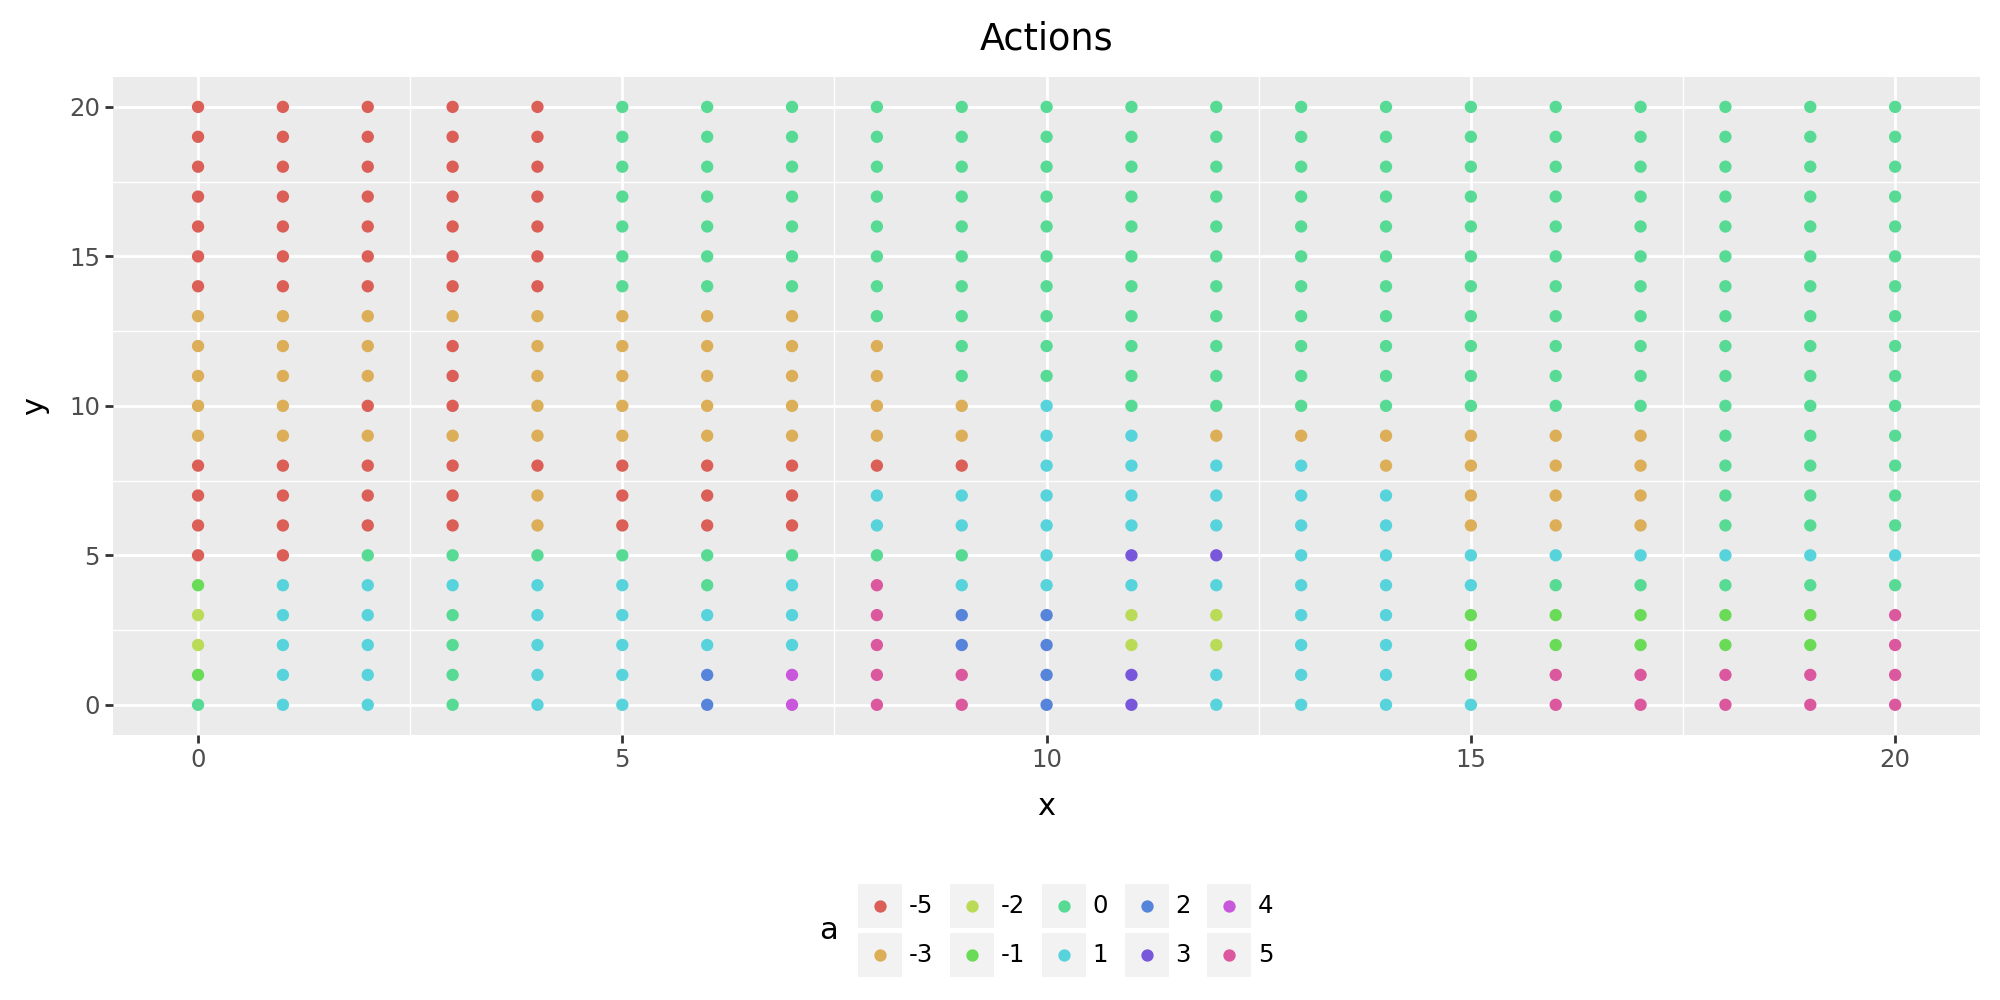

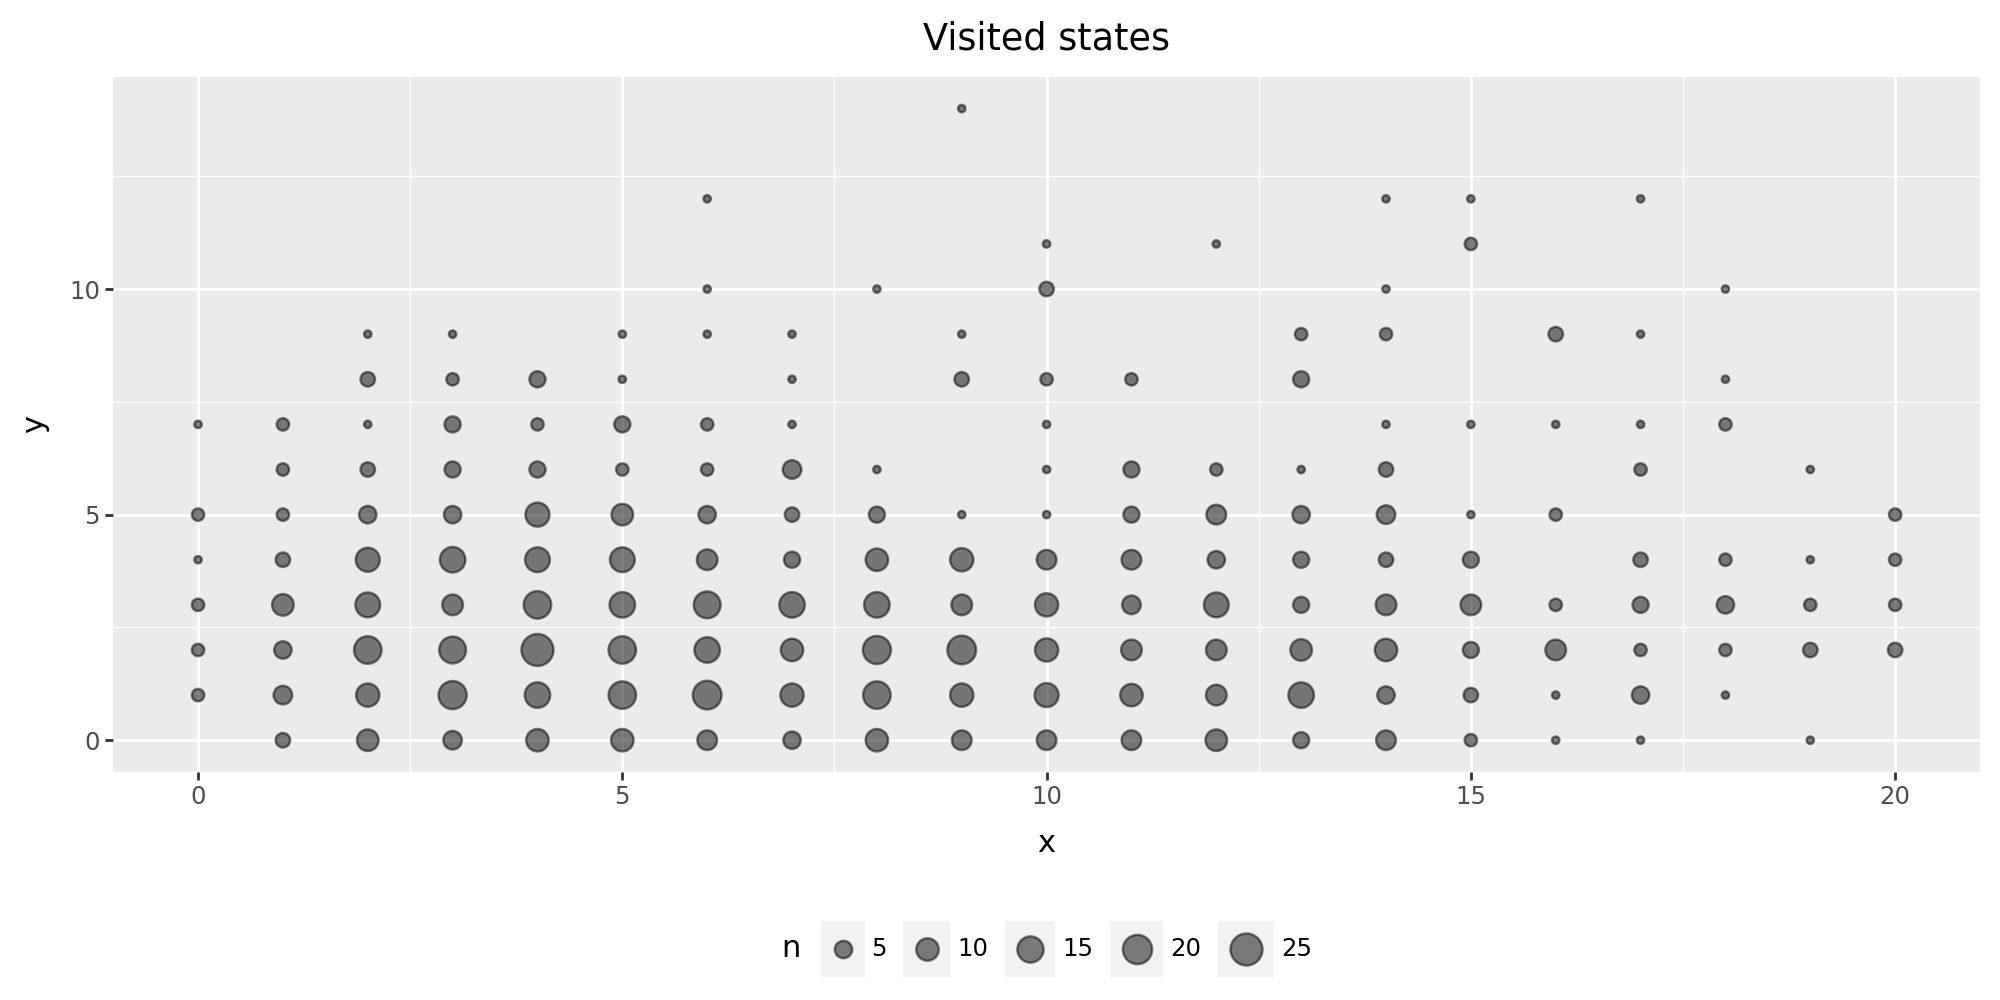

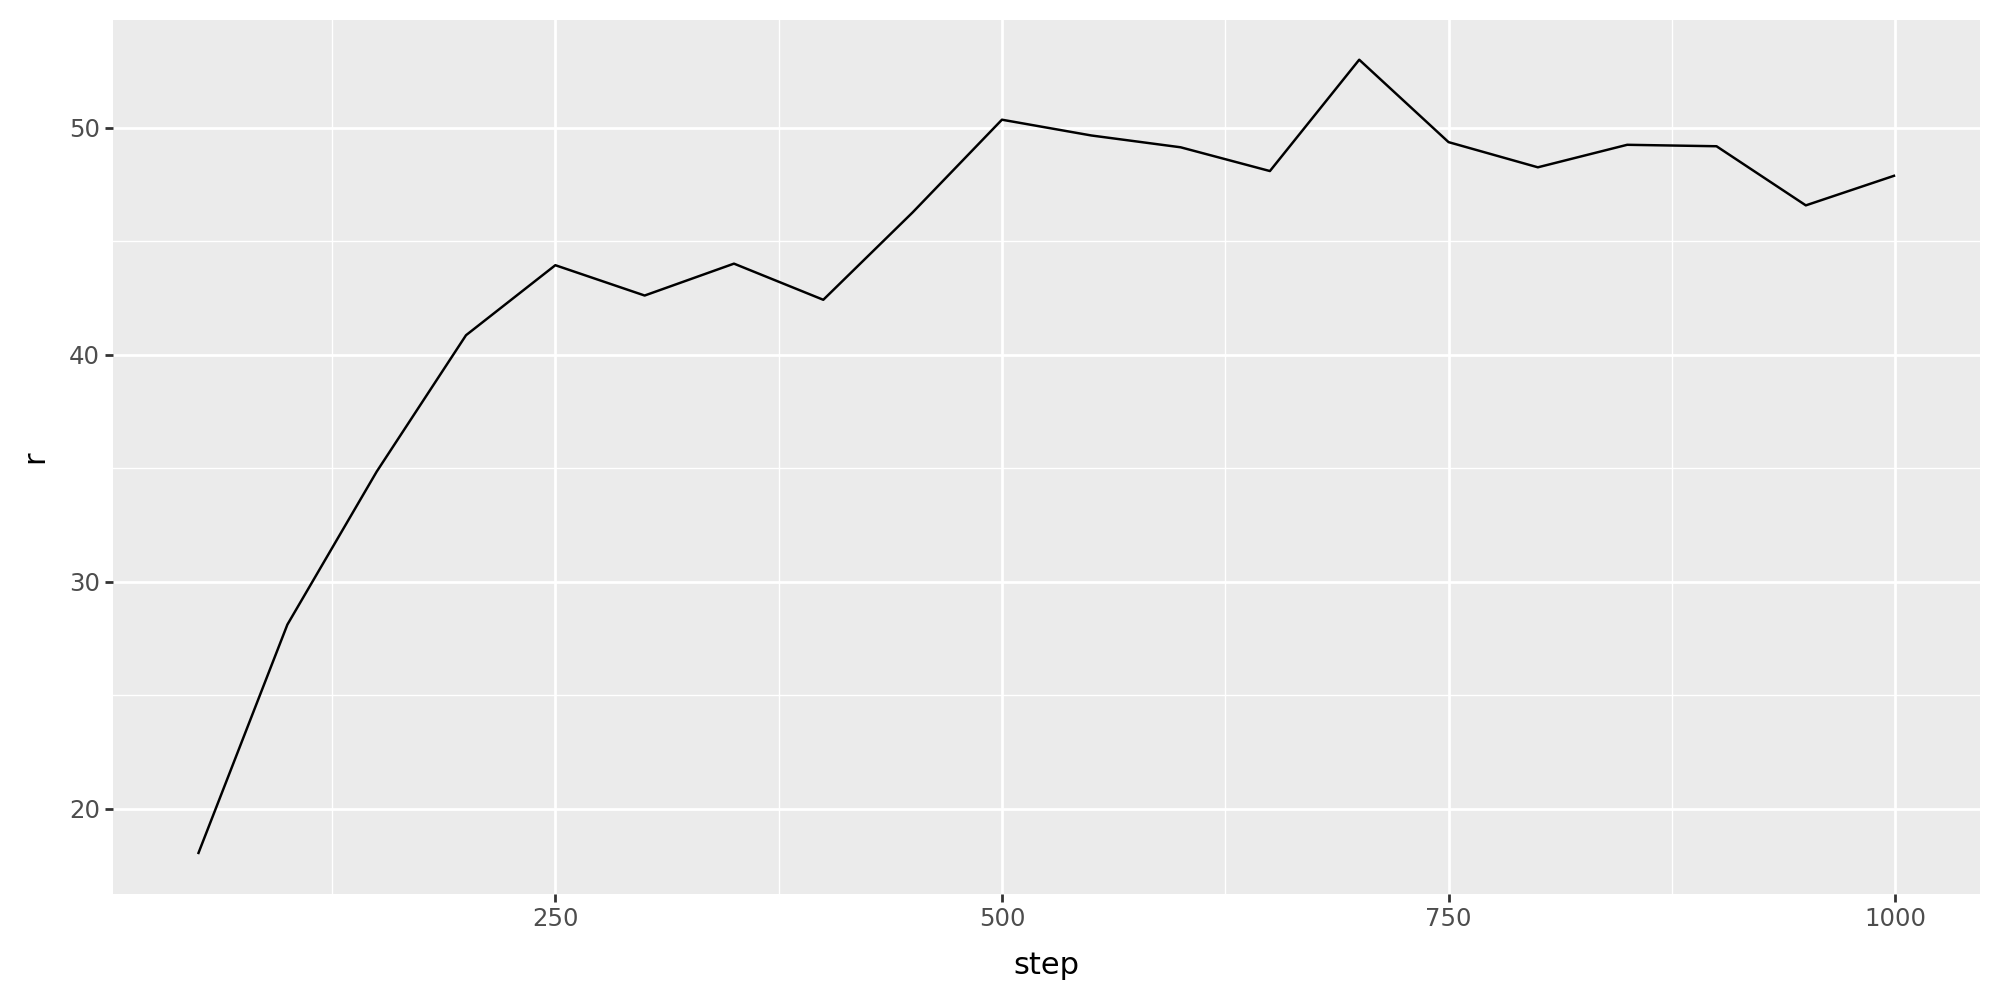

In [ ]:
def callback(func_approx, info, trace):
    """
    Callback for differential (average-reward) semi-gradient Expected SARSA.
    """
    step = info['step']
    # Evaluate learned Q(s,a) → V(s) = max_a Q(s,a)
    q_grid, greedy_actions = eval_state_action_space(func_approx, env)

    val = {
        'q': q_grid,
        'a': greedy_actions,
        'epsilon': info.get('epsilon'),
        'step': step,
        'bar_R': info.get('bar_R'),
    }
    trace.append(val)


def eval_state_action_space(q_hat, env):
    """
    Evaluate Q(s,a).

    Args:
        q_hat: Function approximator with method: q_hat.eval(state, action) -> float
        env: Environment with members env.max_inv, env.max_t, env.get_actions(state)

    Returns:
        q_grid: np.ndarray shape with max_a Q(s,a)
        greedy: pd.DataFrame with columns ['x','y','a'] for argmax_a Q(s,a)
    """
    rows = []
    for x in range(env.cars_max+1):
        for y in range(env.cars_max+1):
            s = [x, y]
            for a in env.get_actions(s):             # includes [scrap_price] at t==max_t
                rows.append((x, y, int(a), q_hat.eval(s, a)))

    dat = pd.DataFrame(rows, columns=['x', 'y', 'a', 'q_hat'])

    # Greedy action per state
    idx = dat.groupby(['x', 'y'])['q_hat'].idxmax()
    greedy = dat.loc[idx, ['x', 'y', 'a']].reset_index(drop=True)

    # Max-Q grid (q as rows, t as columns)
    q_max = dat.groupby(['x', 'y'])['q_hat'].max().reset_index()
    q_grid = q_max.pivot(index='x', columns='y', values='q_hat').values

    return q_grid, greedy

def plot_trace(trace, dat_mdp):
    """
    Plot the max-Q surface for the last snapshot in `trace`, the corresponding
    actions, the visited states and the average reward.
    """
    # last trace and optimal q-values
    plot_q_val(trace, dat_mdp, env)

    # last trace and optimal actions
    dat_a = trace[-1]['a'].copy()  # DataFrame with ['x','y','a']
    dat_a['a'] = pd.Categorical(dat_a['a'])
    pt = (
        ggplot(dat_a, aes(x = "x", y = "y", color = "a"))
        + geom_point()
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(title = "Actions")
    )
    pt.show()

    # visited states
    dat_s = [ [s[0], s[1], q_hat.s_ctr[q_hat.st2idx[s]]] for s in env.get_states()]
    dat_s = pd.DataFrame(dat_s, columns=['x', 'y', 'n'])
    dat_s = dat_s >> mask(X.n > 0)
    pt = (
        ggplot(dat_s, aes(x = 'x', y = 'y', size = 'n'))
        + geom_point(alpha = 0.5)
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(title = "Visited states")
    )
    pt.show()

    # average reward
    step = [t['step'] for t in trace]
    r = [t['bar_R'] for t in trace]
    dat = pd.DataFrame({'step': step, 'ave_reward': r})
    pt = (
        ggplot(dat, aes(x = 'step', y = 'r'))
        + geom_line()
        + theme(figure_size=(10, 5), legend_position='bottom')
    )
    pt.show()

def plot_q_val(trace, dat_mdp, env, id=-1):
    """
    Plot the a Q-surface of a snapshot in `trace`.
    """
    fig = make_subplots(
        rows=1, cols=1,
        specs=[[{"type": "surface"}]],
        subplot_titles=[f"Step {trace[id]['step']}"]
    )

    # --- Data prep ---
    q_arr = np.nan_to_num(trace[id]['q'])
    # tmp = dat_mdp.pivot(index='x', columns='y', values='Value').values
    x = np.arange(0, env.cars_max + 1)
    y = np.arange(0, env.cars_max + 1)
    Y, X = np.meshgrid(y, x)

    # --- Compute global z-range ---
    zmin = np.nanmin([q_arr.min()])
    zmax = np.nanmax([q_arr.max()])

    # --- Surfaces ---
    fig.add_trace(
        go.Surface(x=X, y=Y, z=q_arr, colorscale="Viridis",
                   cmin=zmin, cmax=zmax, showscale=False),
        row=1, col=1
    )
    # fig.add_trace(
    #     go.Surface(x=X, y=Y, z=tmp, colorscale="Viridis",
    #                cmin=zmin, cmax=zmax, showscale=True, colorbar_title="Value"),
    #     row=1, col=2
    # )

    # --- Layout with shared z-axis range ---
    fig.update_layout(
        width=700, height=700,
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="Value",
            zaxis=dict(range=[zmin, zmax])
        ),
        # scene2=dict(
        #     xaxis_title="Inventory (q)",
        #     yaxis_title="Time (t)",
        #     zaxis_title="Value",
        #     zaxis=dict(range=[zmin, zmax])
        # ),
    )

    fig.show()

q_hat.reset()
trace = []
total_steps = 1000
cont_diff_expected_sarsa(
    env=env,
    total_steps=total_steps,
    beta=0.01,
    eps=0.1,
    q_hat=q_hat,
    s_start=(10, 10),
    eps_decay=0.999995,
    callback_every=50,
    callback=callback,
    trace=trace
)
plot_trace(trace, dat_mdp)

#### Q5

1) Give a short summary of all the functions and their purpose.

   *Your comments*

2) Is the output reasonable?

   *Your comments*


#### Q6

* Run the algorithm using 100000 steps, with `callback_every = 5000`.
* Comment on your results.
* Give an interpretation of $q(s,a)$, e.g. that does it mean if $q((3,15), -4) = 10$ or $-5$?

In [ ]:
#@title Solution

# Your code

display(Markdown("""
Your comments
"""))

#### Q7

- Could another function approximation be suitable here?

  *Your comments*

- Apply your suggestion to the problem.

  *See code below*

In [ ]:
#@title Solution

# Your code